In [17]:
%matplotlib inline

In [18]:
import iris
from iris.analysis import maths as iam
from iris import plot as iplt
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import numpy as np
from skimage.measure import EllipseModel

In [19]:
from nonstationary_cov import cube_covariance as cube_cov

In [20]:
sns.set_theme()

For the purpose of fitting ellipses, the rims are dropped:

Ellipses are only fitted for (x: 4:-4, y: 4:-4)

Since original domain is 16x16, so it x=(4...11) and y=(4...11)

fit_ellipse_unit_tests.py

Fixed parameters only

fit_ellipse_unit_tests_variable_parms.py

Parameters uderlying variable scales:

- 'sdev=0.6, Lx=1900~2600 [E(Lx)=2250], Ly=700~1050 [E(Ly)=875], \n theta=0, v=1.5',:
    --   (1.5,
         [lambda x, y: 0.6+0.0*x+0.0*y, 
          lambda x, y: 1500.+100.*x+0.*y,
          lambda x, y: 500.+0.*x+50.*y, 
          lambda x, y: 0.+0.*x+0.*y],

    -- at x=4, y=4: sdev=0.6, Lx=1900, Ly=700, theta=0

    -- at x=11, y=11: sdev=0.6, Lx=2600, Ly=1050, theta=0

- 'sdev=0.64~1.46, Lx=1900~2600 [E(Lx)=2250], Ly=700~1050  [E(Ly)=875], \n theta=0, v=1.5',
    --   (1.5,
         [lambda x, y: 0.6+0.05*x+0.01*y, 
          lambda x, y: 1500.+100.*x+0.*y,
          lambda x, y: 500.+0.*x+50.*y, 
          lambda x, y: 0.+0.*x+0.*y], 

    -- at x=4, y=4: sdev=0.84, Lx=1900, Ly=700, theta=0

    -- at x=11, y=11: sdev=1.26, Lx=2600, Ly=1050, theta=0

- 'sdev=0.64~1.46, Lx=1900~2600 [E(Lx)=2250], Ly=700~1050[E(Ly)=875], \n theta=11~30deg, v=1.5'
    --   (1.5,
         [lambda x, y: 0.6+0.05*x+0.01*y, 
          lambda x, y: 1500.+100.*x+0.*y,
          lambda x, y: 500.+0.*x+50.*y, 
          lambda x, y: 0.+0.*x+np.pi/4/16.*y],
          
    -- at x=4, y=4: sdev=0.84, Lx=1900, Ly=700, theta=0.196

    -- at x=11, y=11: sdev=1.26, Lx=2600, Ly=1050, theta=0.54

In [21]:
simulated_ellipse_path = "../tests_and_examples/test_data/"
simulated_ellipse_types = [
    "constant_1000_unrotated_1p5",
    "Lx1300_Ly1100_unrotated_1p5",
    "Lx1300_Ly1100_45deg_1p5",
    "Lx1500_Ly1000_unrotated_1p5",
    "Lx1500_Ly1000_45deg_1p5",
    "variable_scales_1p5_fixed_sdev_fixed_angle",
    "variable_scales_1p5_variable_sdev_fixed_angle",
    "variable_scales_1p5_variable_sdev_variable_angle",
]
simulated_ellipse_verbals = [
    "sdev=0.6, istropic Lx=Ly=1000km v=1.5 \n [theta has no meaning for a circle, but code always estimates it]",
    "sdev=0.6, Lx=1300, Ly=1100, theta=0, v=1.5, eccentricity=0.533",
    "sdev=0.6, Lx=1300, Ly=1100, theta=45deg, v=1.5, eccentricity=0.533",
    "sdev=0.6, Lx=1500, Ly=1000, theta=0, v=1.5, eccentricity=0.533",
    "sdev=0.6, Lx=1500, Ly=1000, theta=45deg, v=1.5, eccentricity=0.533",
    "sdev=0.6, Lx=1900~2600 [E(Lx)=2250], Ly=700~1050 [E(Ly)=875], \n theta=0, v=1.5",
    "sdev=0.64~1.46, Lx=1900~2600 [E(Lx)=2250], Ly=700~1050  [E(Ly)=875], \n theta=0, v=1.5",
    "sdev=0.64~1.46, Lx=1900~2600 [E(Lx)=2250], Ly=700~1050[E(Ly)=875], \n theta=11~30deg, v=1.5",
]
vminss = [
    [900, 900, -45, 0.55],
    [1200, 1000, -45, 0.55],
    [1200, 1000, 0, 0.55],
    [1400, 900, -45, 0.55],
    [1400, 900, 0, 0.55],
    [1700, 600, -45, 0.55],
    [1700, 600, -45, 0.74],
    [1700, 600, -25, 0.74],
]
vmaxss = [
    [1100, 1100, 45, 0.65],
    [1400, 1200, 45, 0.65],
    [1400, 1200, 90, 0.65],
    [1600, 1100, 45, 0.65],
    [1600, 1100, 90, 0.65],
    [2700, 1100, 45, 0.65],
    [2700, 1100, 45, 1.36],
    [2700, 1100, 65, 1.36],
]
correct_parms = [
    (1000.0, 1000.0, 0.0, 0.6),
    (1300.0, 1100.0, 0.0, 0.6),
    (1300.0, 1100.0, np.pi / 4, 0.6),
    (1500.0, 1000.0, 0.0, 0.6),
    (1500.0, 1000.0, np.pi / 4, 0.6),
    None,
    None,
    None,
]
check_flips = [False, False, True, False, True, False, False, True]
# simulated_ellipse_types = ['constant_1000_unrotated_1p5']
# simulated_ellipse_verbals = ['sdev=0.6, istropic 1000km v=1.5']
# vminss = [[900, 900, -45, 0.55]]
# vmaxss = [[1100, 1100, 45, 0.65]]
# check_flips = [False]
simulated_ellipse_ncfiles = [
    simulated_ellipse_path + simulated_ellipse_type + ".nc"
    for simulated_ellipse_type in simulated_ellipse_types
]
simulated_ellipse_figfiles = [
    simulated_ellipse_path + simulated_ellipse_type + ".png"
    for simulated_ellipse_type in simulated_ellipse_types
]

In [22]:
# Lx_cmap = Ly_cmap = sdev_cmap = 'PuBu'
Lx_cmap = Ly_cmap = sdev_cmap = "seismic"
theta_cmap = "seismic"
eccentrcity_cmap = "PuBu"
geomean_cmap = "PuBu"

In [23]:
def swap_Lx_Ly_if_Lx_lt_Ly(lx, ly, the):
    lx_new = lx.copy()
    ly_new = ly.copy()
    the_new = the.copy()
    where_backwards = ly.data > lx.data
    if np.any(where_backwards):
        lx_new.data[where_backwards] = ly.data[where_backwards]
        ly_new.data[where_backwards] = lx.data[where_backwards]
        the_new.data[where_backwards] = (
            the_new.data[where_backwards] + np.pi / 2
        )
    the_new.data[the_new.data > np.pi / 2] = (
        the_new.data[the_new.data > np.pi / 2] - np.pi
    )
    the_new.data[the_new.data < -np.pi / 2] = (
        the_new.data[the_new.data < -np.pi / 2] + np.pi
    )
    return lx_new, ly_new, the_new

In [24]:
def eccentricity_data_func(axis0_data, axis1_data):
    major_axis = np.maximum(axis1_data, axis0_data)
    minor_axis = np.minimum(axis1_data, axis0_data)
    return np.sqrt(1.0 - minor_axis**2 / major_axis**2)


def eccentricity_units_func(axis0_cube, axis1_cube):
    if axis0_cube.units != getattr(axis0_cube, "units", axis1_cube.units):
        raise ValueError("units do not match")
    return "1"


eccentricity_ifunc = iam.IFunc(eccentricity_data_func, eccentricity_units_func)

In [25]:
def average_LxLyTheta(lx, ly, the, check_flip=False):
    """
    Averages Lx, Ly, theta
    ans = Lx, Ly, E(theta) in deg
    """
    sigmas = []
    zipper = zip(lx.slices([]), ly.slices([]), the.slices([]))
    for lx_mini, ly_mini, the_mini in zipper:
        sigma = cube_cov.sigma_rot_func(
            lx_mini.data, ly_mini.data, the_mini.data
        )
        sigmas.append(sigma)
    sigmas = np.array(sigmas)
    print(sigmas.shape)
    sigma_bar = np.mean(sigmas, axis=0)
    print(sigma_bar)
    eval, evec = np.linalg.eig(sigma_bar)
    E_lx = np.sqrt(eval[0])
    E_ly = np.sqrt(eval[1])
    E_the = np.arctan2(evec[1, 0], evec[0, 0])
    if check_flip:
        if E_lx < E_ly:
            moo = E_lx
            E_lx = E_ly
            E_ly = moo
            E_the += np.pi / 2
    if E_the > np.pi / 2:
        E_the -= np.pi
    if E_the < -np.pi / 2:
        E_the += np.pi
    E_the_deg = np.rad2deg(E_the)
    return (E_lx, E_ly, E_the_deg)

In [26]:
def draw_ellipses(ax, Lxs, Lys, thetas, vmin=500, vmax=5000, scaling=1000):
    plt.sca(ax)
    geomean = iam.exponentiate(iam.multiply(Lxs, Lys), 0.5)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    iplt.pcolor(geomean, norm=norm, cmap=geomean_cmap)
    cbar = plt.colorbar(location="bottom", orientation="horizontal", pad=0.01)
    zipper = zip(
        Lxs.slices(["latitude"]),
        Lys.slices(["latitude"]),
        thetas.slices(["latitude"]),
    )
    for _, (Lx_x, Ly_x, theta_x) in enumerate(zipper):
        zipper = zip(Lx_x.slices([]), Ly_x.slices([]), theta_x.slices([]))
        for single_cube_count, (Lx, Ly, theta) in enumerate(zipper):
            if np.ma.is_masked(Lx.data):
                continue
            x0 = Lx.coord("longitude").points
            y0 = Lx.coord("latitude").points
            Lx = Lx.data
            Ly = Ly.data
            angle = theta.data
            params = (x0, y0, Lx / scaling, Ly / scaling, angle)
            xys = EllipseModel().predict_xy(
                np.linspace(0, 2 * np.pi, 25), params=params
            )
            ax.plot(
                xys[:, 0],
                xys[:, 1],
                linewidth=2,
                color="blue",
                transform=ccrs.PlateCarree(),
            )
    plt.title("Ellipses & SQRT(LxLy)", size=22)

In [27]:
def pcolor_parm(
    ax, cube, cube_name, vmin_vmax, cmap, parm_mean=None, parm_mean_name=None
):
    plt.sca(ax)
    print(repr(cube))
    print(cube_name)
    print(cube.data.min(), cube.data.max())
    # iplt.contourf(cube, vmin=vmin_vmax[0], vmax=vmin_vmax[1], cmap=cmap)
    norm = mcolors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1], clip=True)
    iplt.pcolor(cube, norm=norm, cmap=cmap)
    cbar = plt.colorbar(location="bottom", orientation="horizontal", pad=0.01)
    cbar.ax.tick_params(labelsize=16)
    if parm_mean is not None:
        parm_mean_num = np.round(parm_mean.data, 2)
        if parm_mean_name is None:
            parm_mean_name = "mean"
        title_str = cube_name + "; " + parm_mean_name + "=" + str(parm_mean_num)
    else:
        title_str = cube_name
    plt.title(title_str, size=22)

In [28]:
def plot_parms(
    parm_cubes,
    verbal_description,
    vmins,
    vmaxs,
    check_flip,
    kwargs4pcolor_parm={},
):
    # plt.subplots(nrows, ncols, figsize=(width, height))
    fig, axs = plt.subplots(
        2, 3, figsize=(22, 15), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    #
    Lx = parm_cubes.extract("Lx")[0]
    Ly = parm_cubes.extract("Ly")[0]
    theta = parm_cubes.extract("theta")[0]
    Lx2, Ly2, theta2 = swap_Lx_Ly_if_Lx_lt_Ly(Lx, Ly, theta)
    theta_x = theta2.copy()
    theta_x.convert_units("degrees")
    sdev = parm_cubes.extract("standard_deviation")[0]
    #
    ELx, ELy, Etheta = average_LxLyTheta(
        Lx2, Ly2, theta2, check_flip=check_flip
    )
    sdev_mean = np.sqrt(np.ma.mean(np.square(sdev.data)))
    #
    eccentricity = eccentricity_ifunc(Lx2, Ly2, new_name="eccentricity")
    Eeccentrcity = eccentricity_data_func(ELx, ELy)
    print(
        "eccentrcity range:", eccentricity.data.min(), eccentricity.data.max()
    )
    zipper = zip(
        axs.flatten()[:-1],
        [Lx2, Ly2, theta_x, sdev, eccentricity],
        ["Lx", "Ly", "theta", "sdev", "eccentricity"],
        [ELx, ELy, Etheta, sdev_mean, Eeccentrcity],
        [
            (vmins[0], vmaxs[0]),
            (vmins[1], vmaxs[1]),
            (vmins[2], vmaxs[2]),
            (vmins[3], vmaxs[3]),
            (0.0, 1.0),
        ],
        [Lx_cmap, Ly_cmap, theta_cmap, sdev_cmap, eccentrcity_cmap],
    )
    for ax, cube, cube_name, parm_mean, vmin_vmax, cmap in zipper:
        pcolor_parm(
            ax,
            cube,
            cube_name,
            vmin_vmax,
            cmap,
            parm_mean=parm_mean,
            **kwargs4pcolor_parm,
        )
    draw_ellipses(
        axs.flatten()[-1],
        Lx2,
        Ly2,
        theta2,
        vmin=0.5 * (vmins[0] + vmins[1]),
        vmax=0.5 * (vmaxs[0] + vmaxs[1]),
    )
    fig.suptitle(verbal_description, size=24)
    plt.tight_layout()

(64, 2, 2)
[[1002458.00374817    8449.68826535]
 [   8449.68826535  980060.00601746]]
eccentrcity range: 0.032433968 0.3844873
<iris 'Cube' of Lx / (km) (latitude: 8; longitude: 8)>
Lx
976.3533 1069.8547
<iris 'Cube' of Ly / (km) (latitude: 8; longitude: 8)>
Ly
942.98834 1022.3616
<iris 'Cube' of theta / (degrees) (latitude: 8; longitude: 8)>
theta
-63.56428 89.96546
<iris 'Cube' of standard_deviation / (K) (latitude: 8; longitude: 8)>
sdev
0.5827829 0.61856467
<iris 'Cube' of eccentricity / (1) (latitude: 8; longitude: 8)>
eccentricity
0.032433968 0.3844873
(64, 2, 2)
[[1681818.73812646   -7678.5867479 ]
 [  -7678.5867479  1195502.02554542]]
eccentrcity range: 0.4502607 0.5857148
<iris 'Cube' of Lx / (km) (latitude: 8; longitude: 8)>
Lx
1251.5828 1328.1223
<iris 'Cube' of Ly / (km) (latitude: 8; longitude: 8)>
Ly
1058.3508 1140.3086
<iris 'Cube' of theta / (degrees) (latitude: 8; longitude: 8)>
theta
-11.861103 9.091462
<iris 'Cube' of standard_deviation / (K) (latitude: 8; longitude:

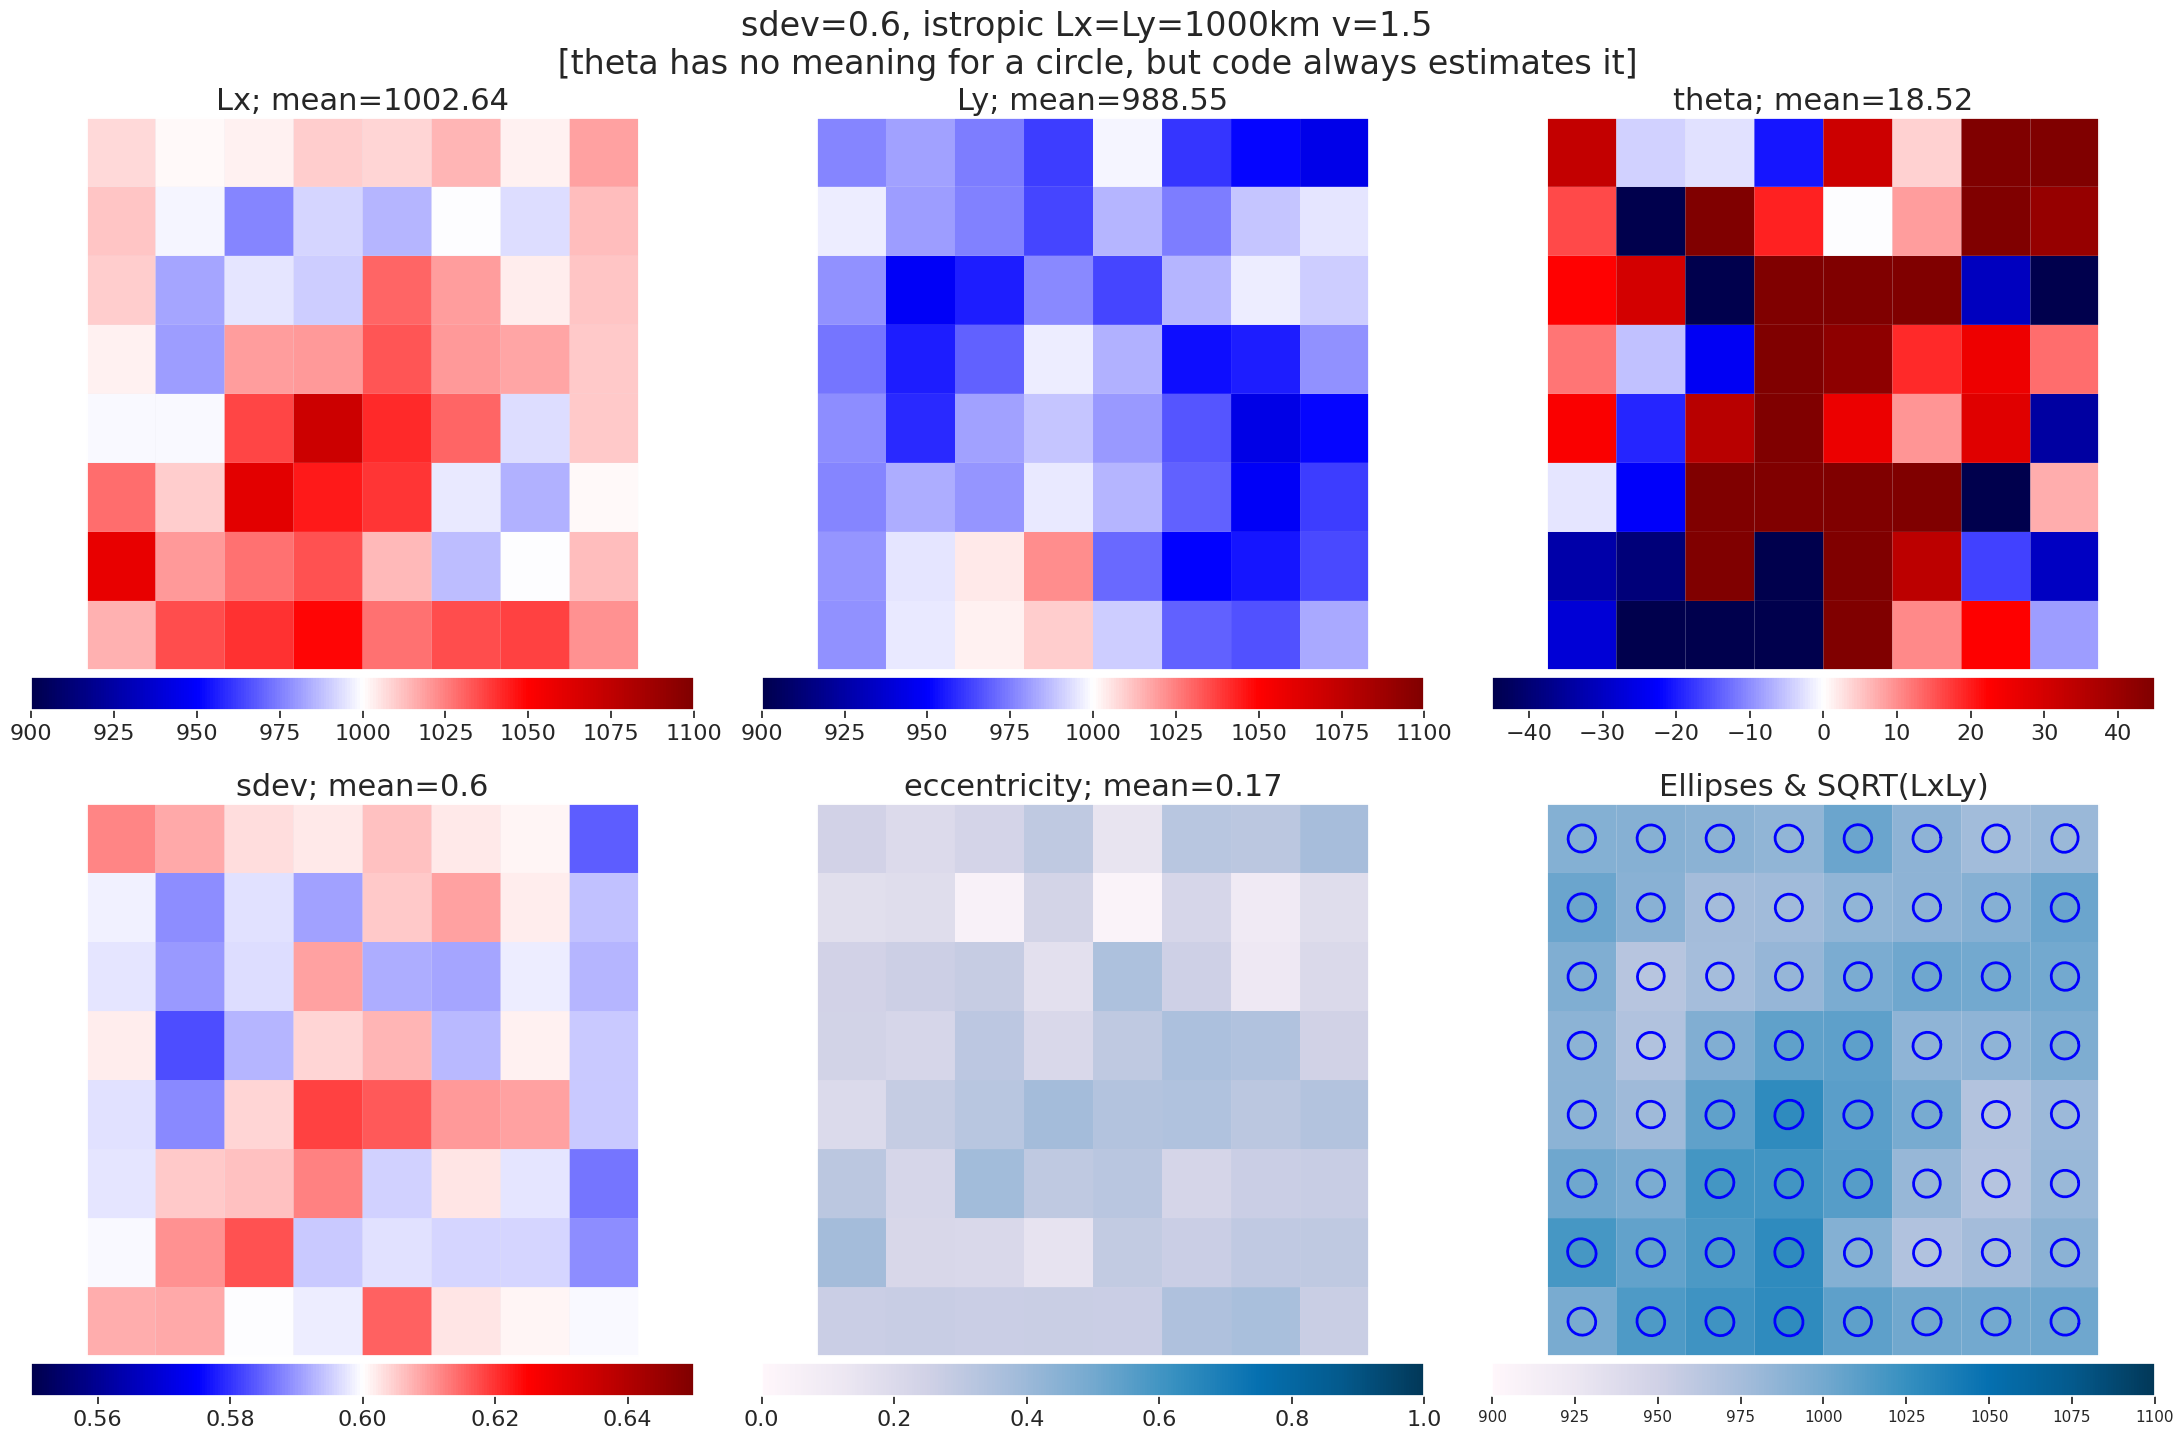

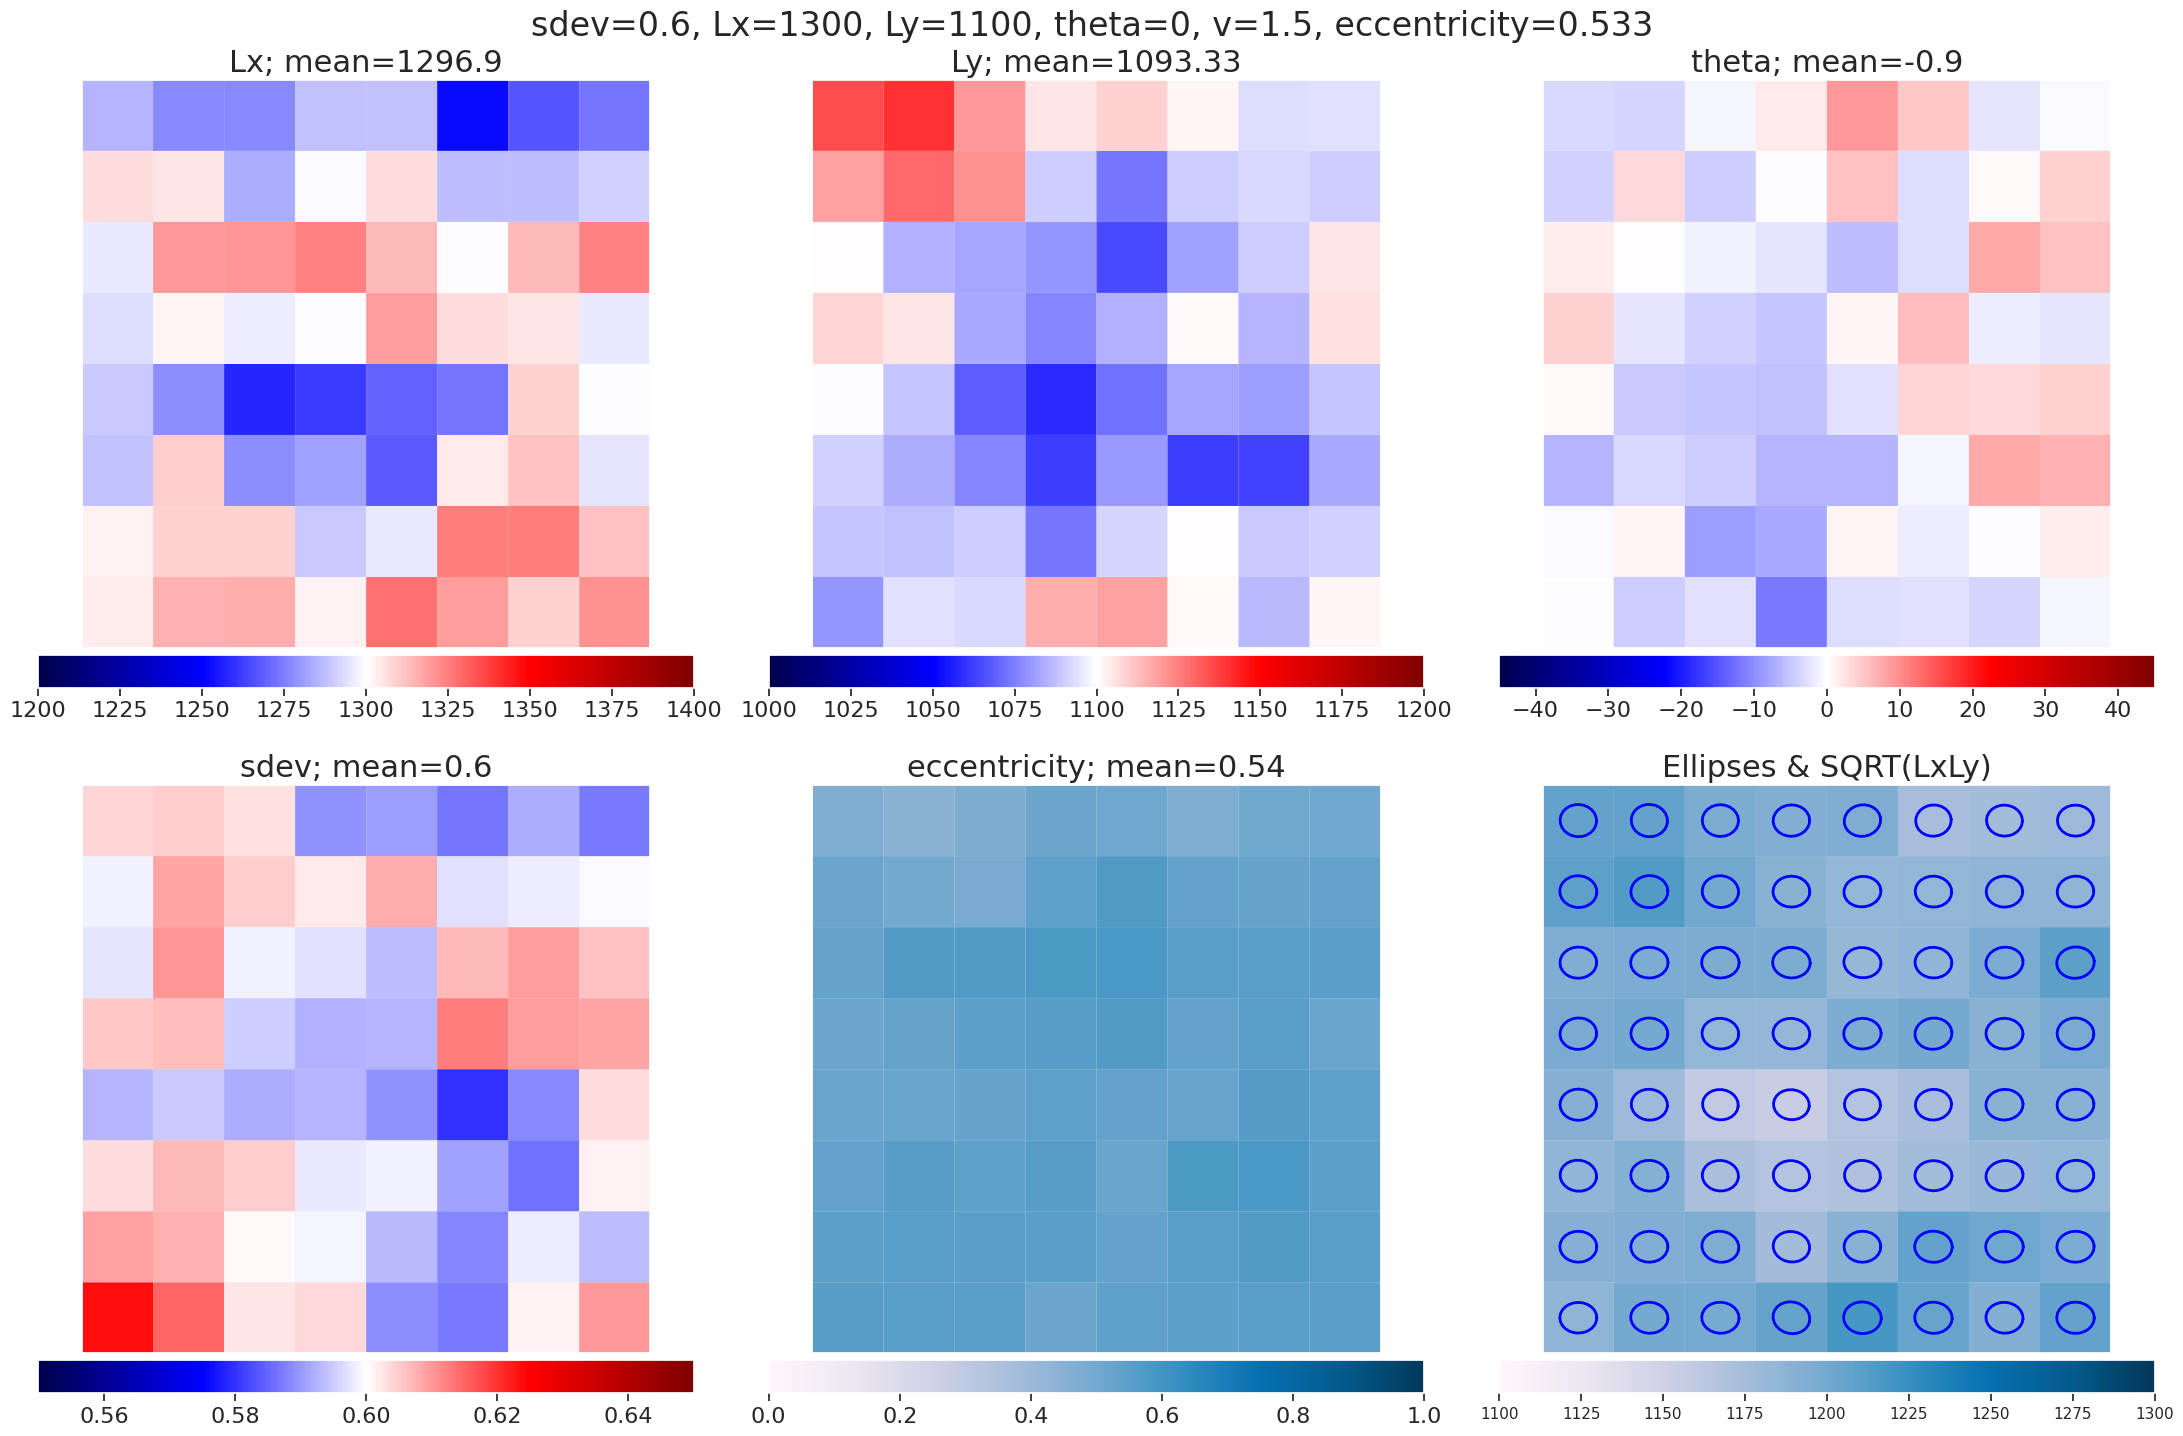

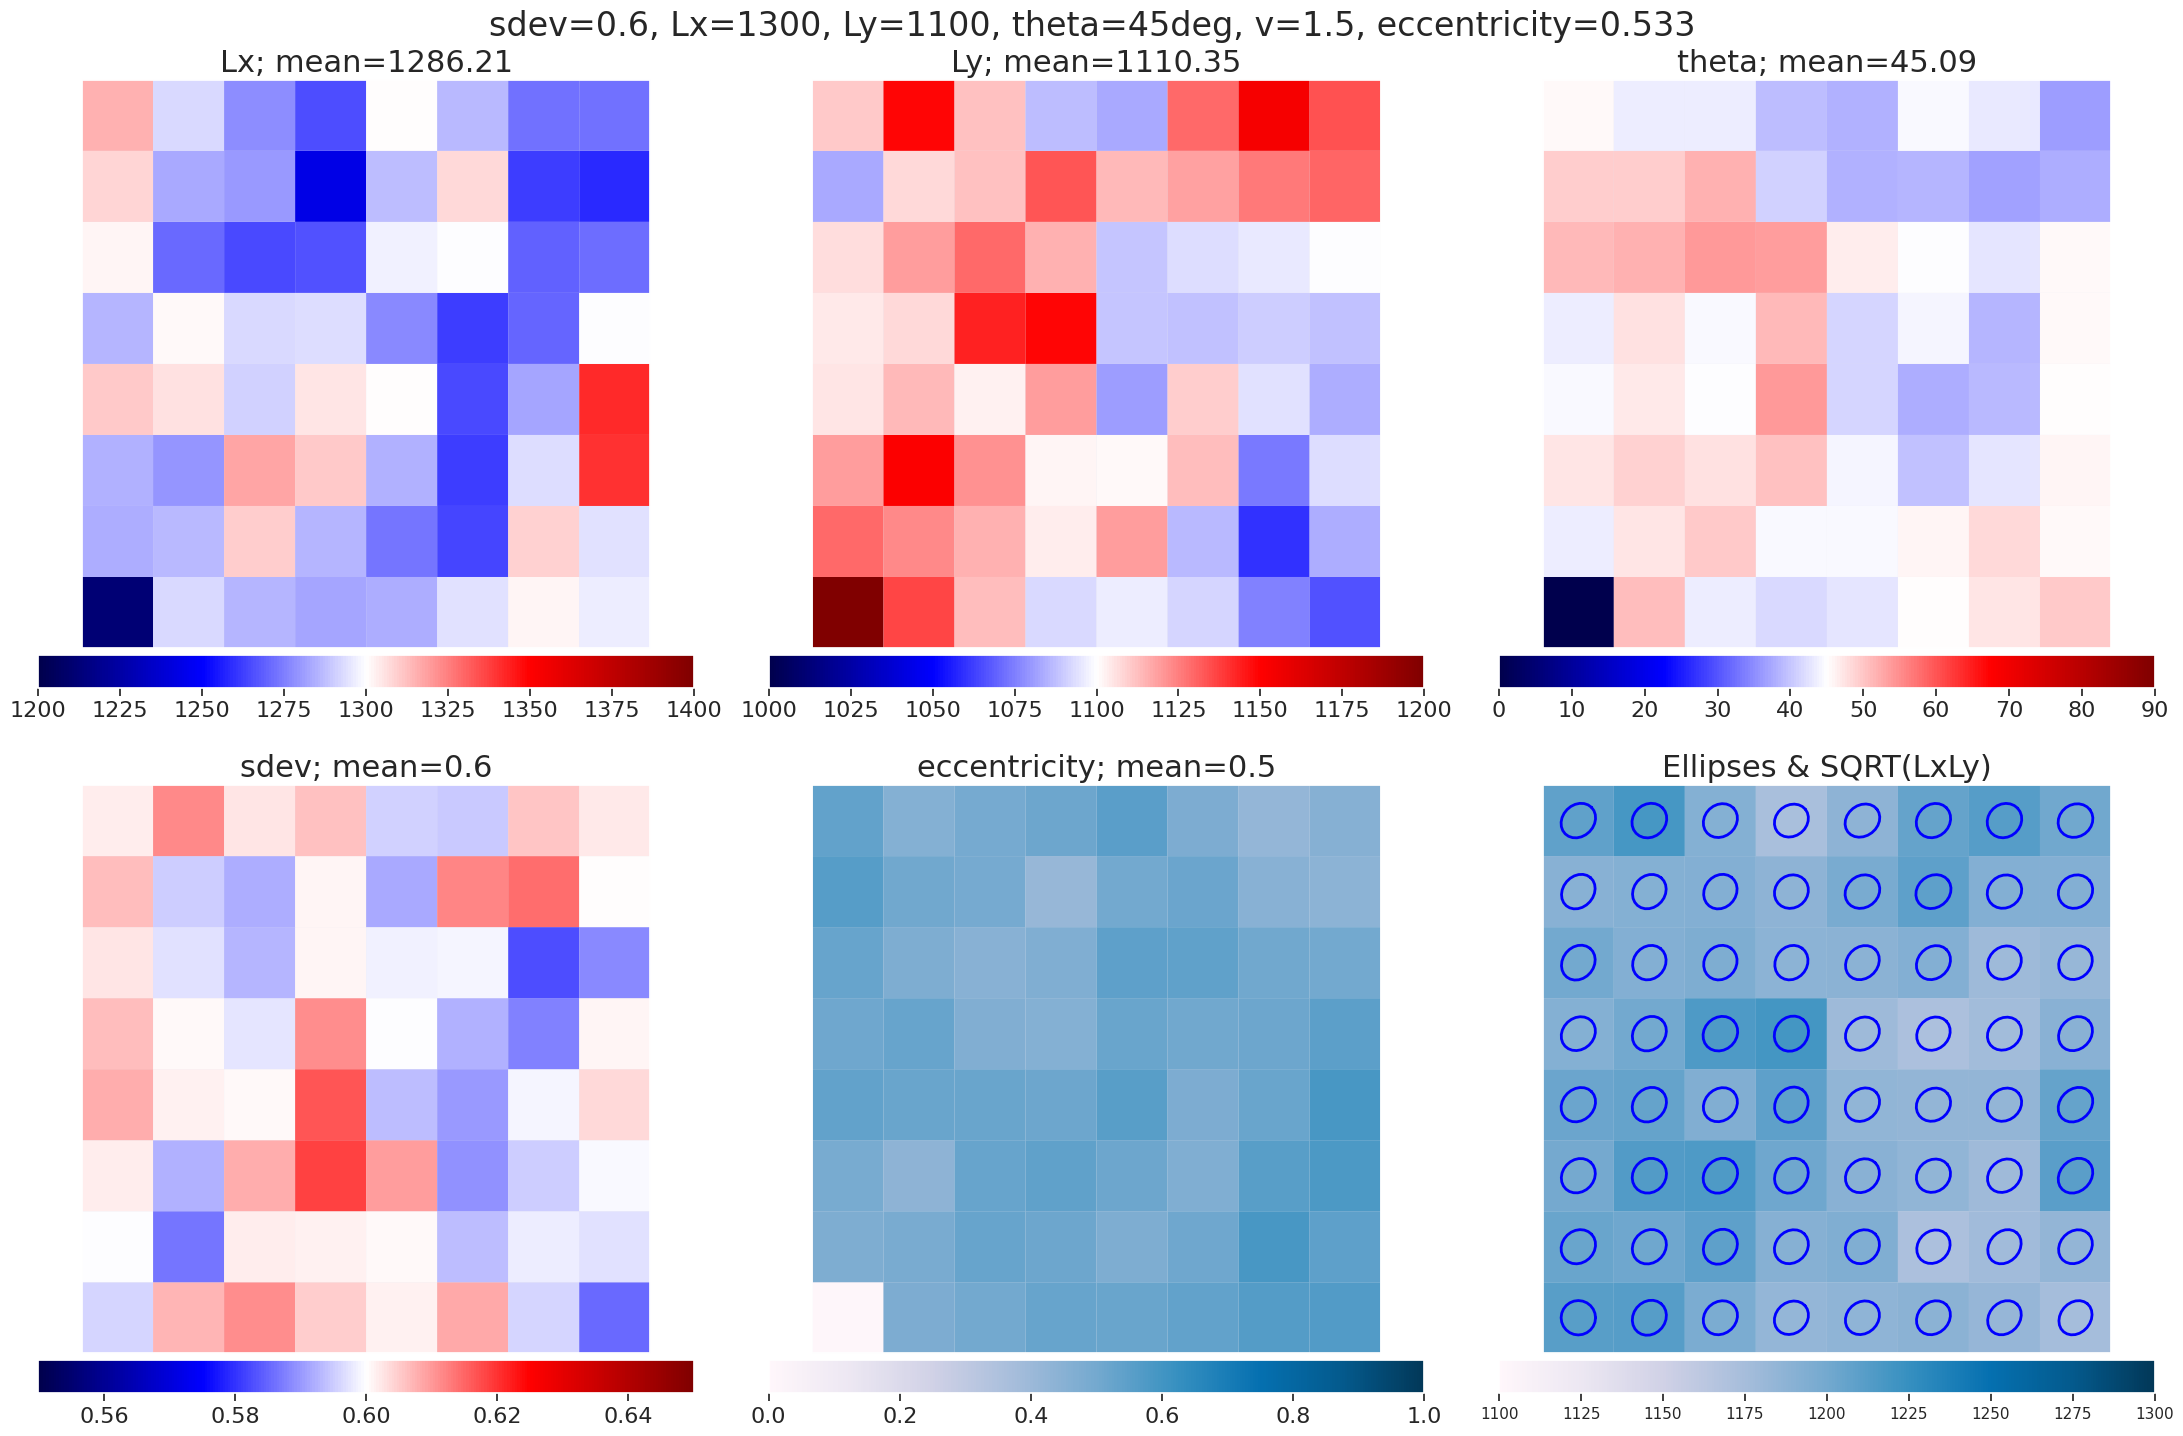

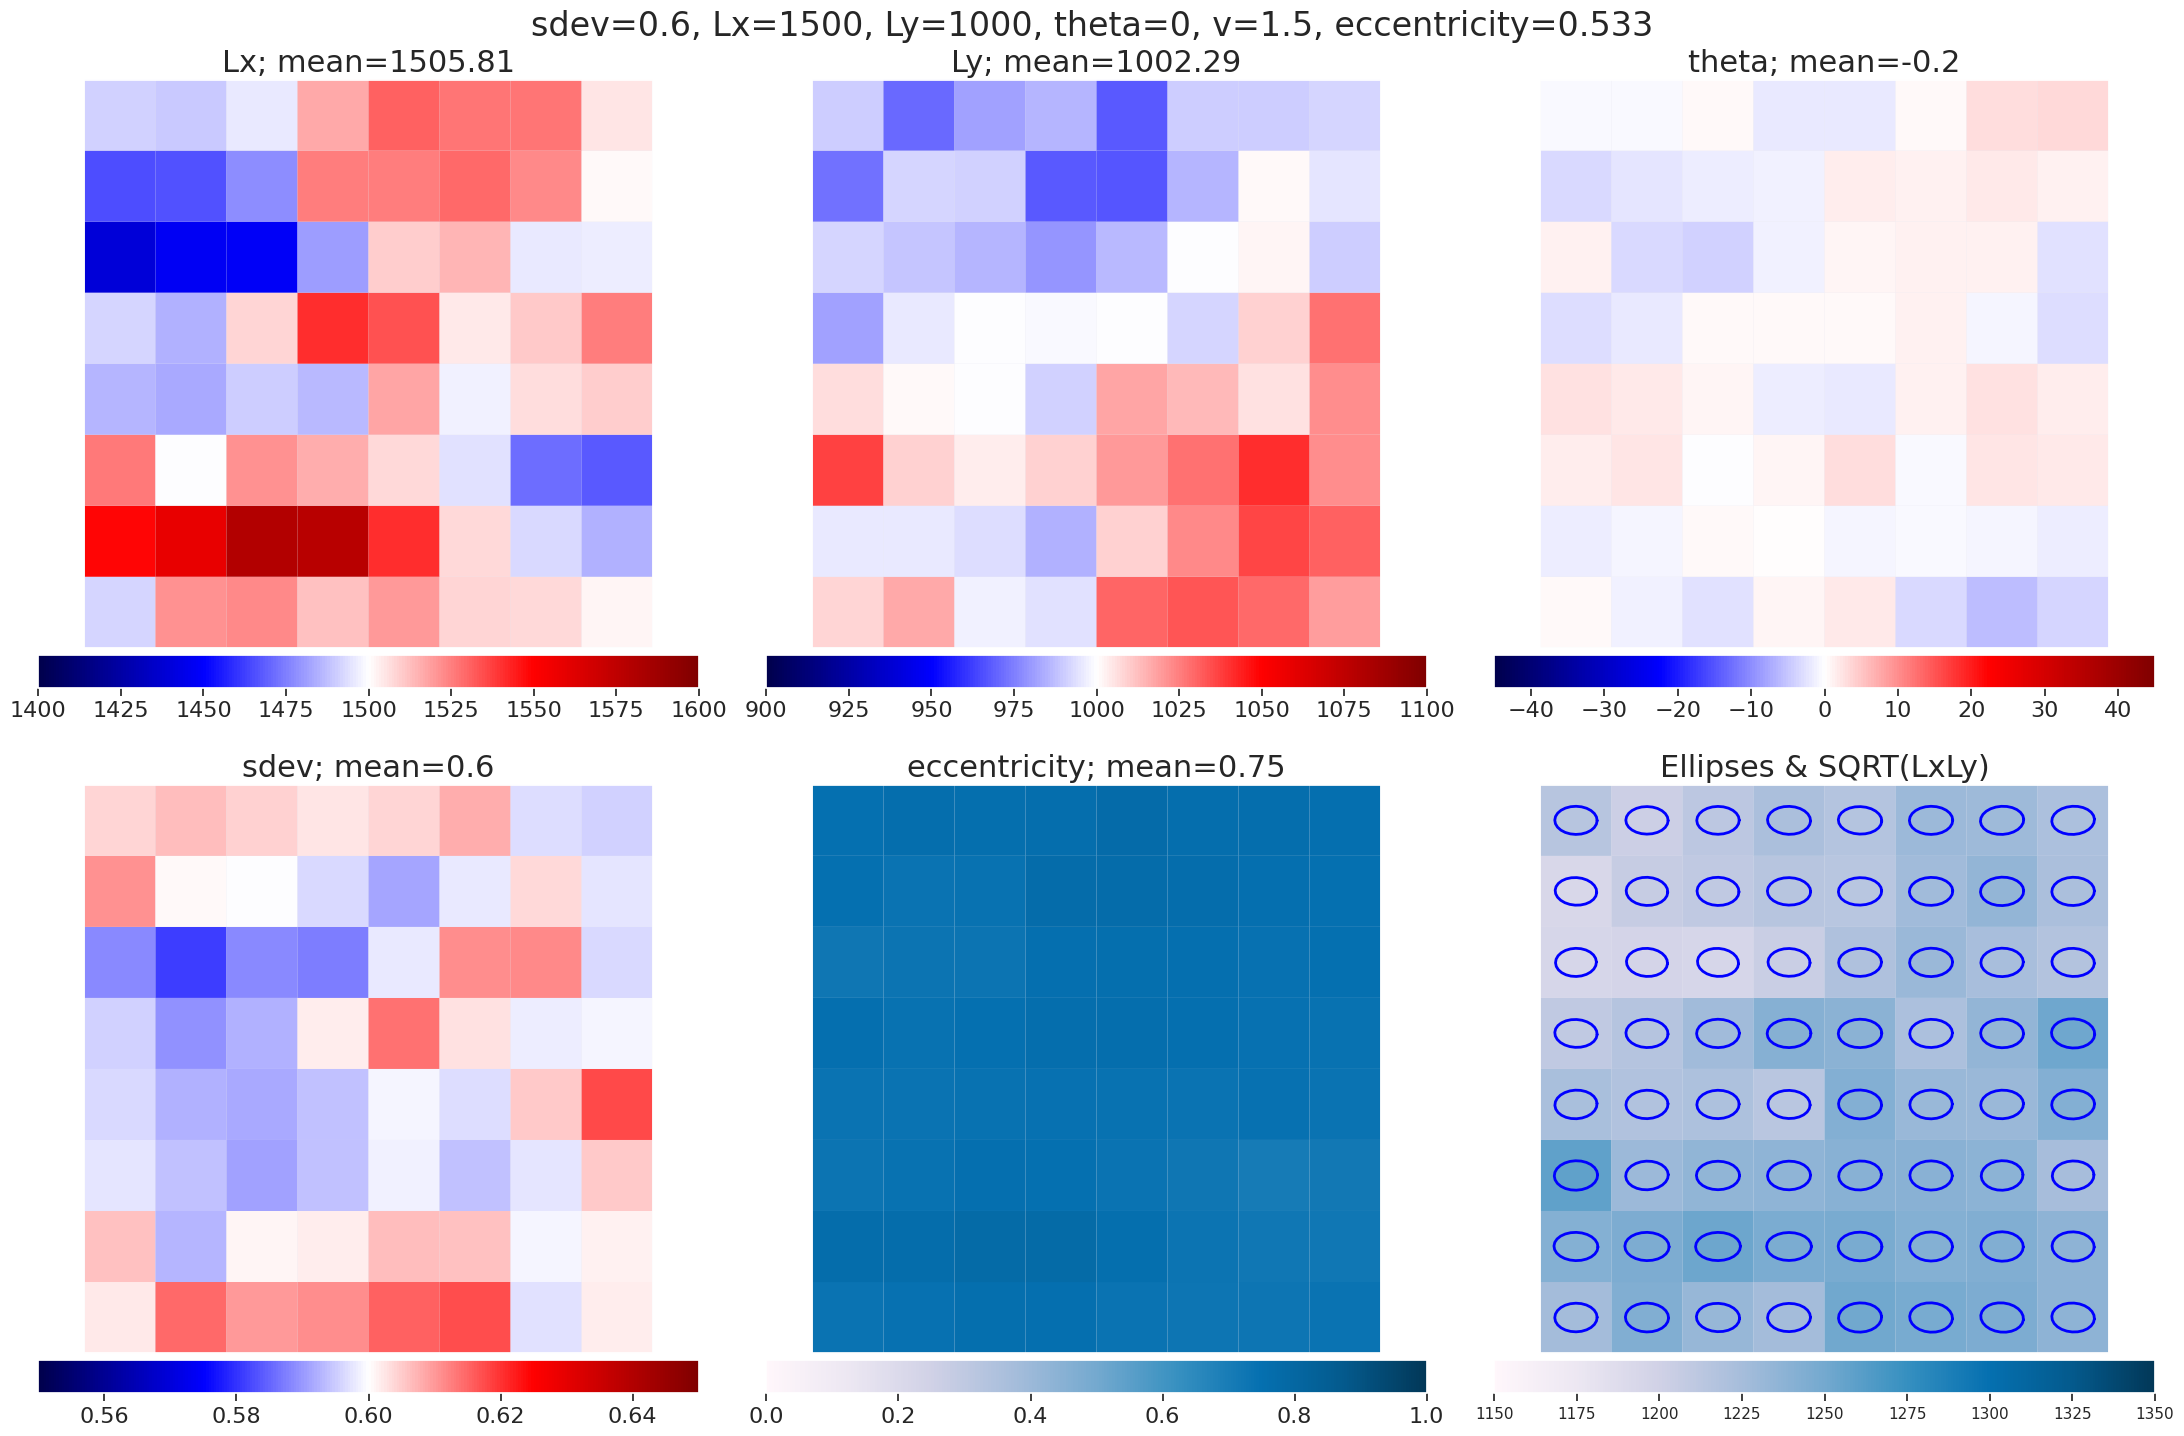

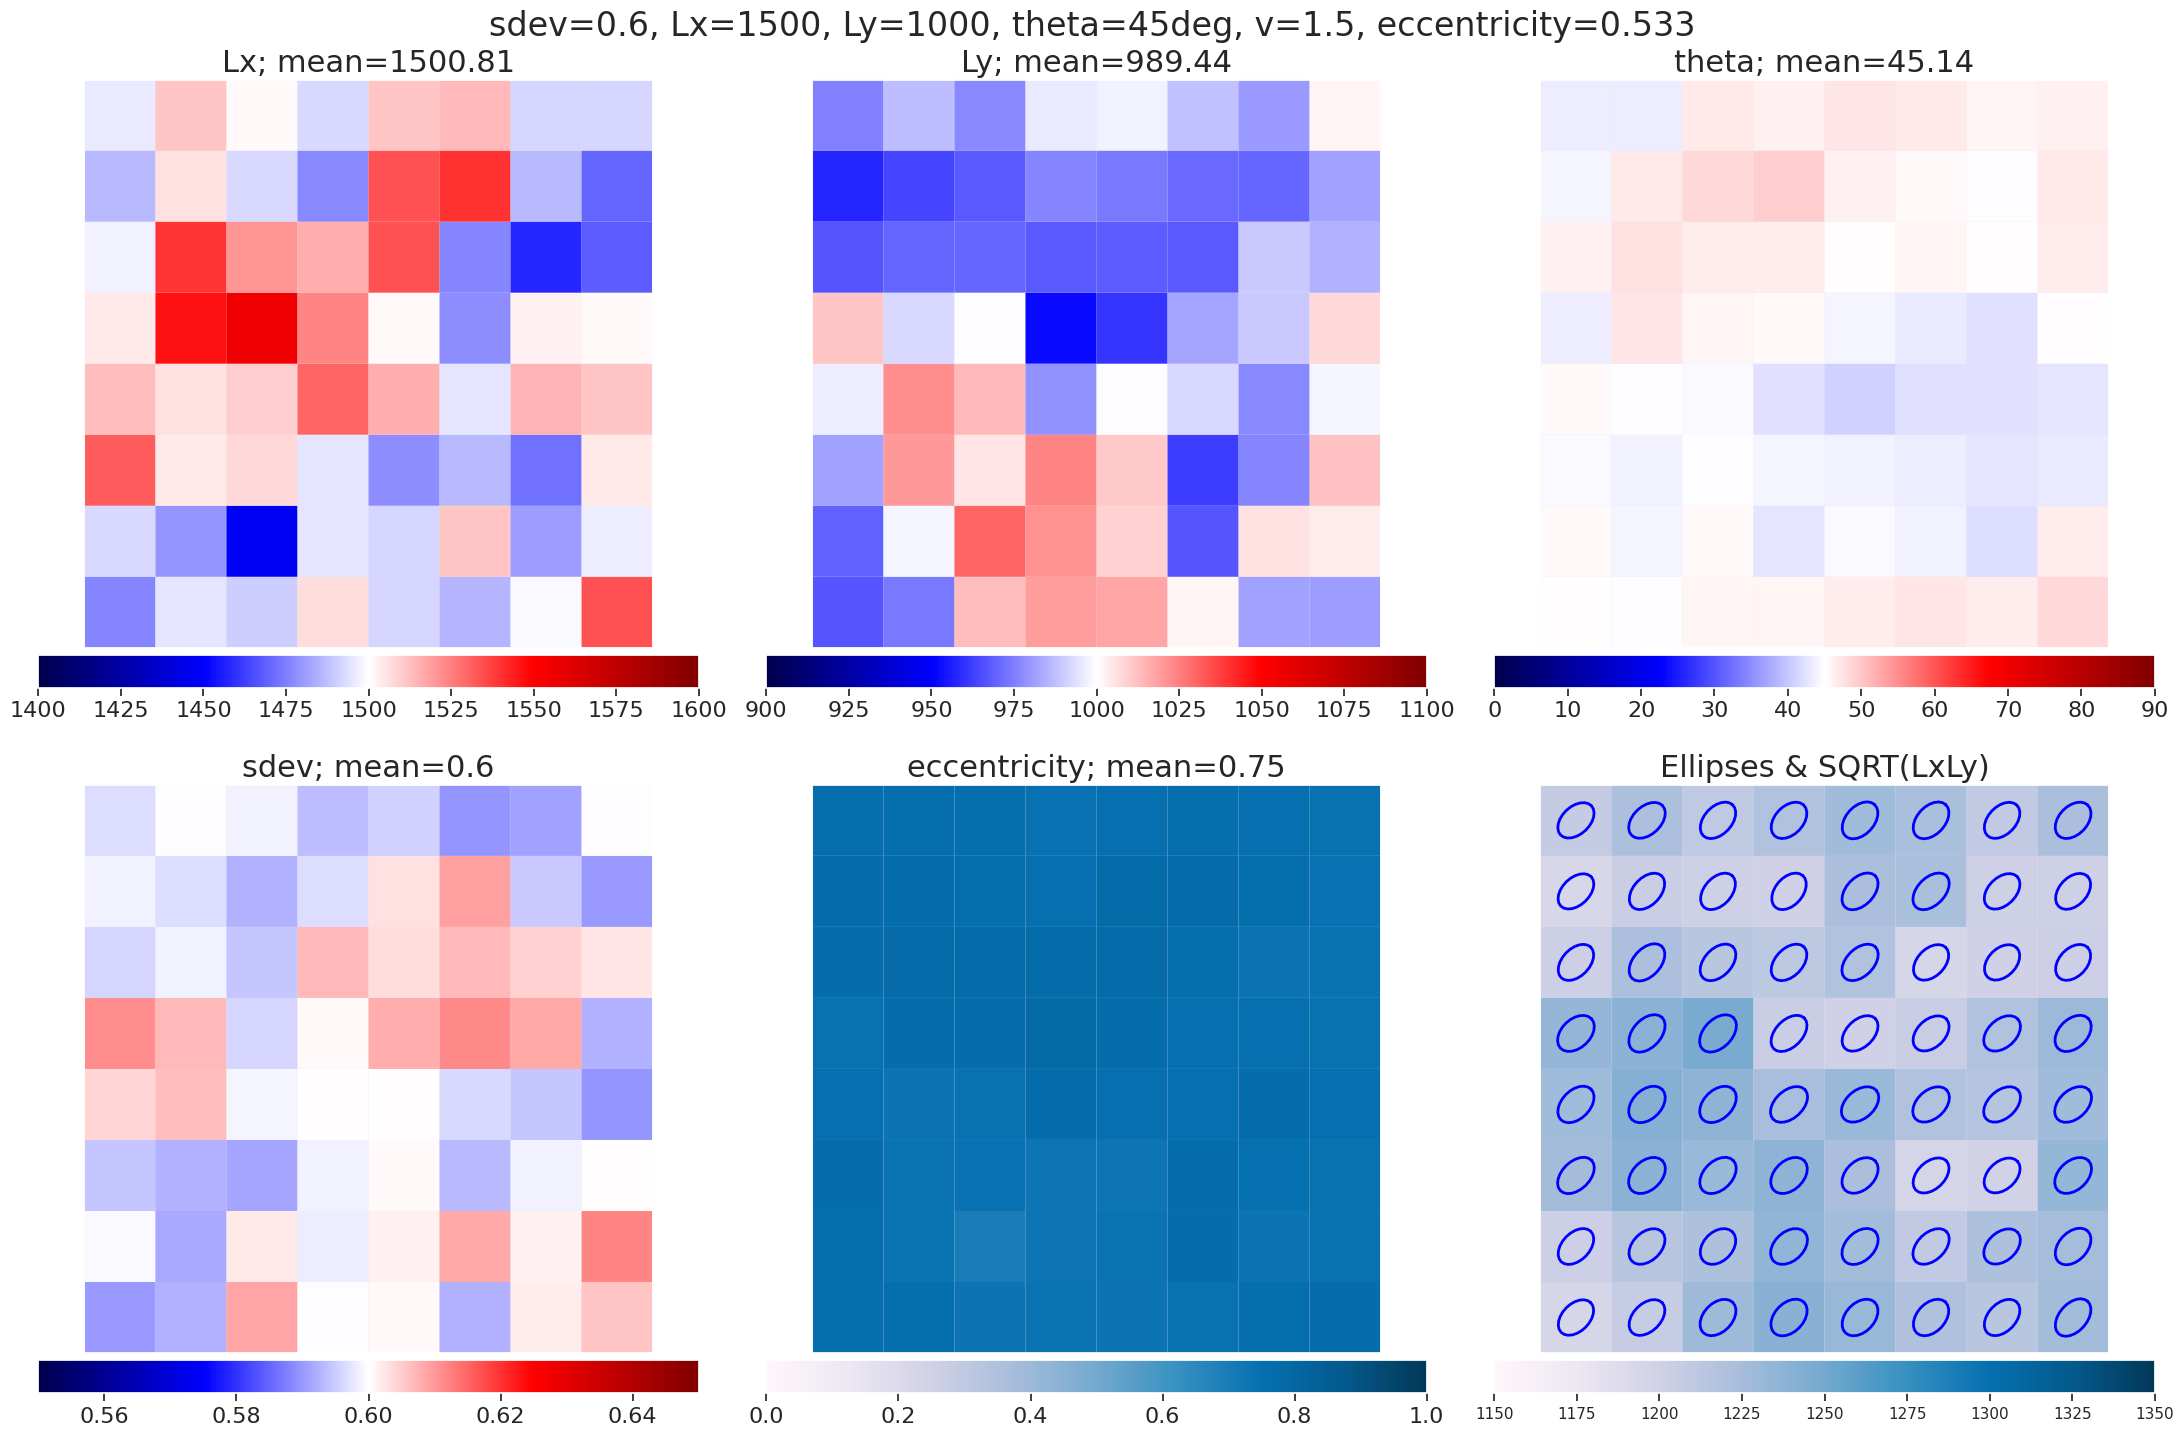

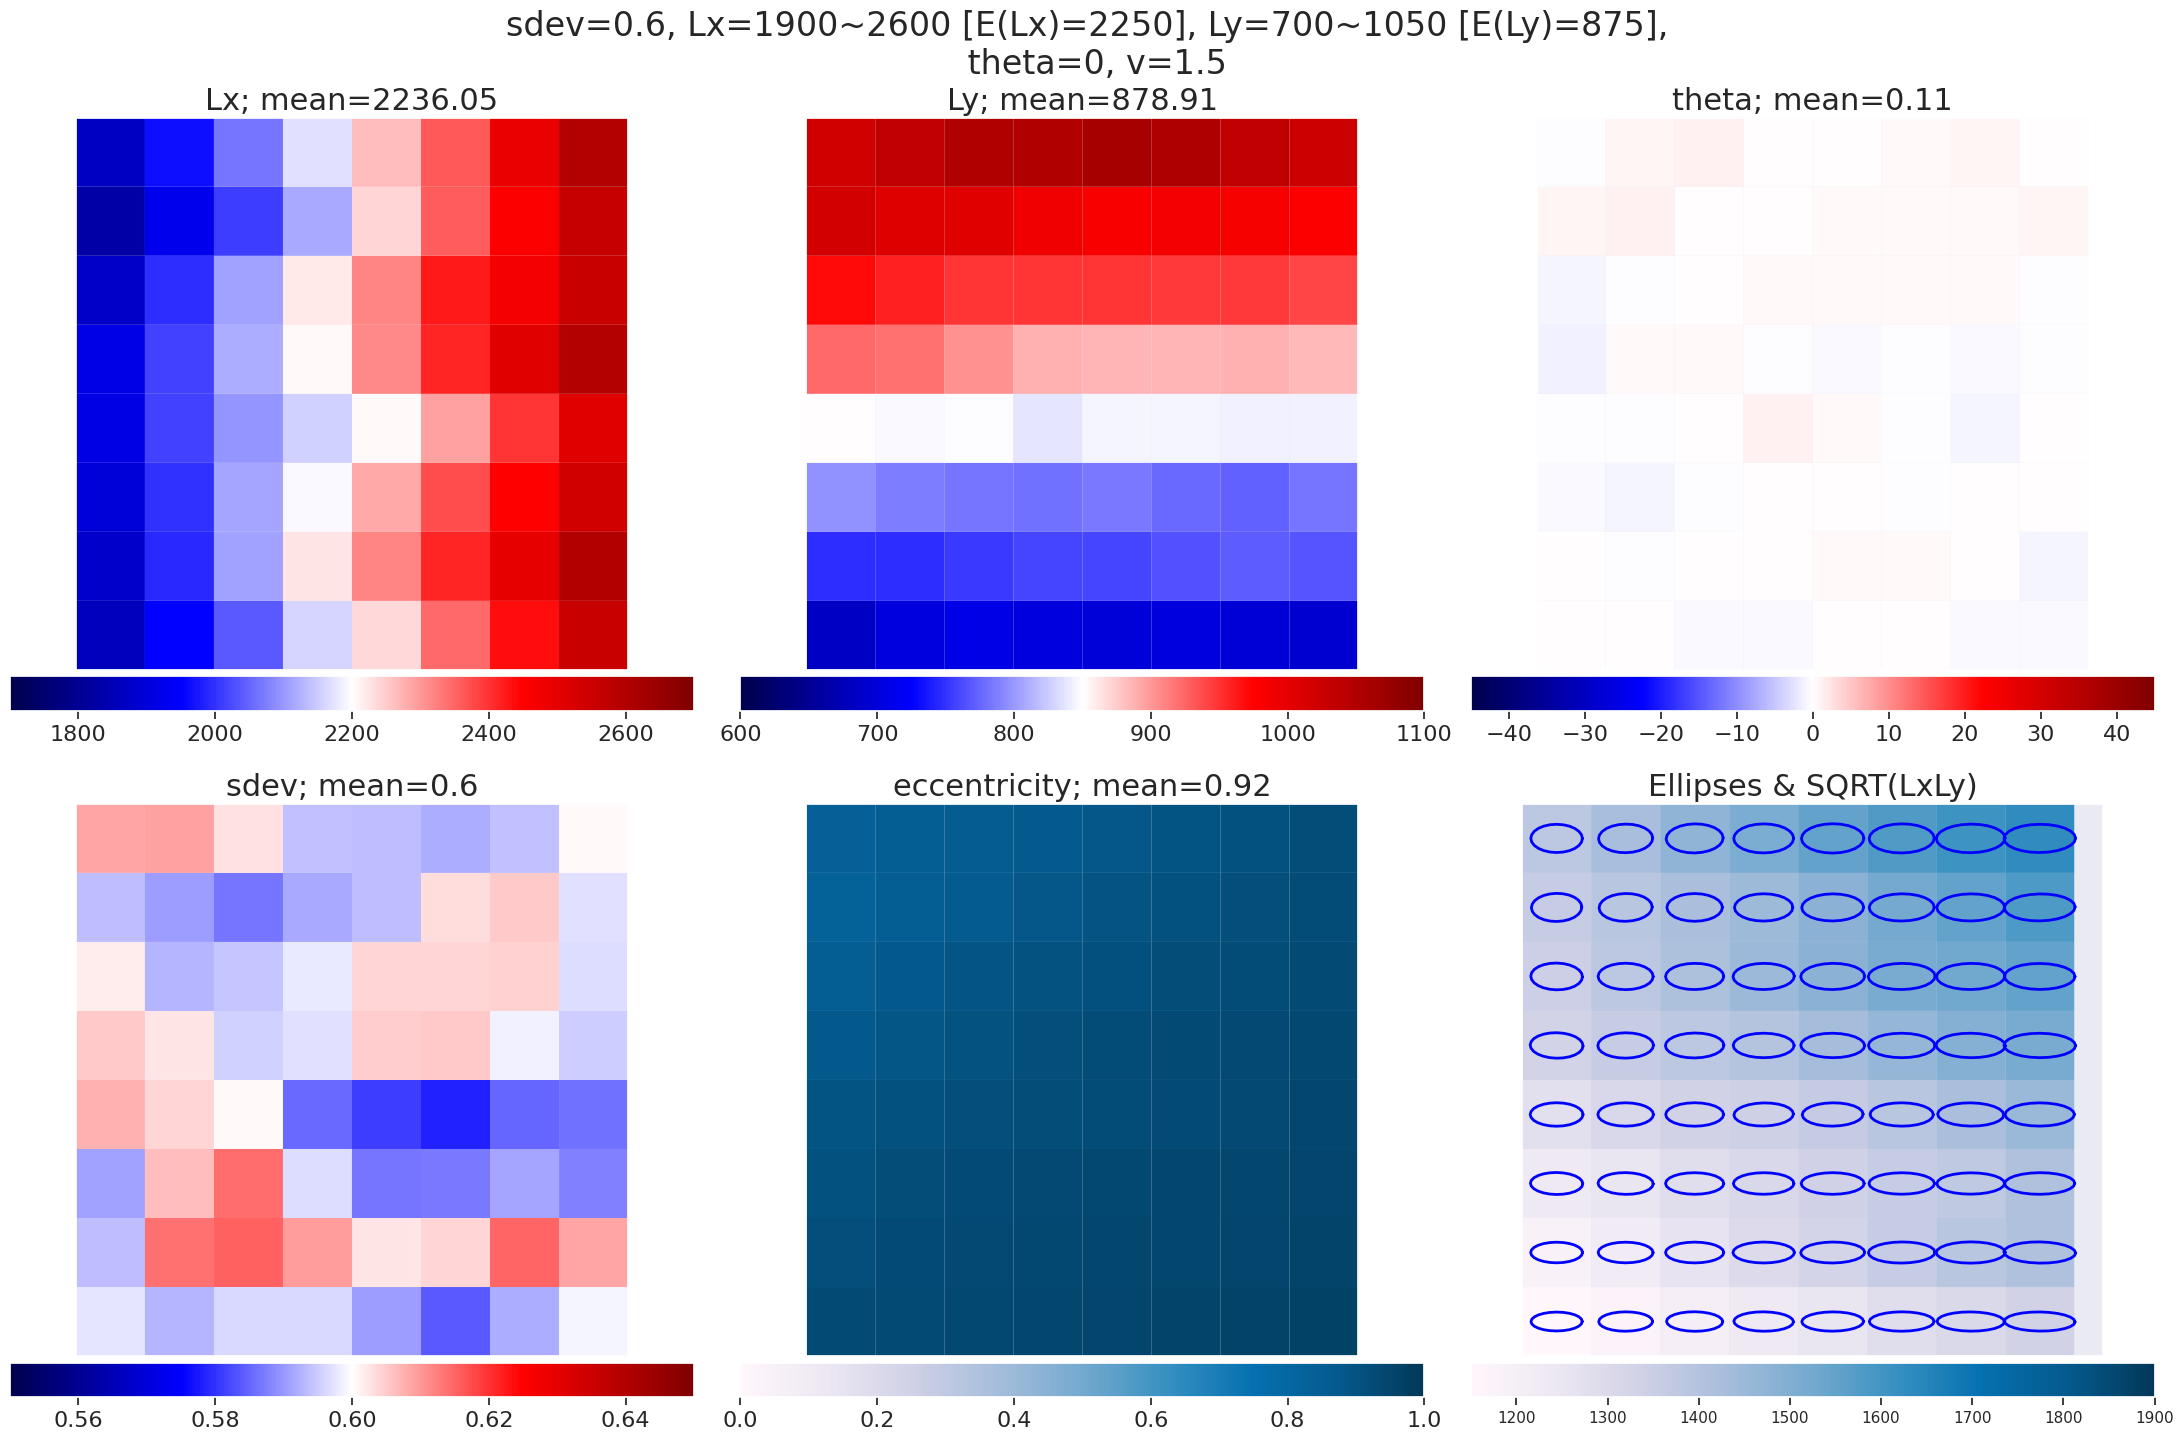

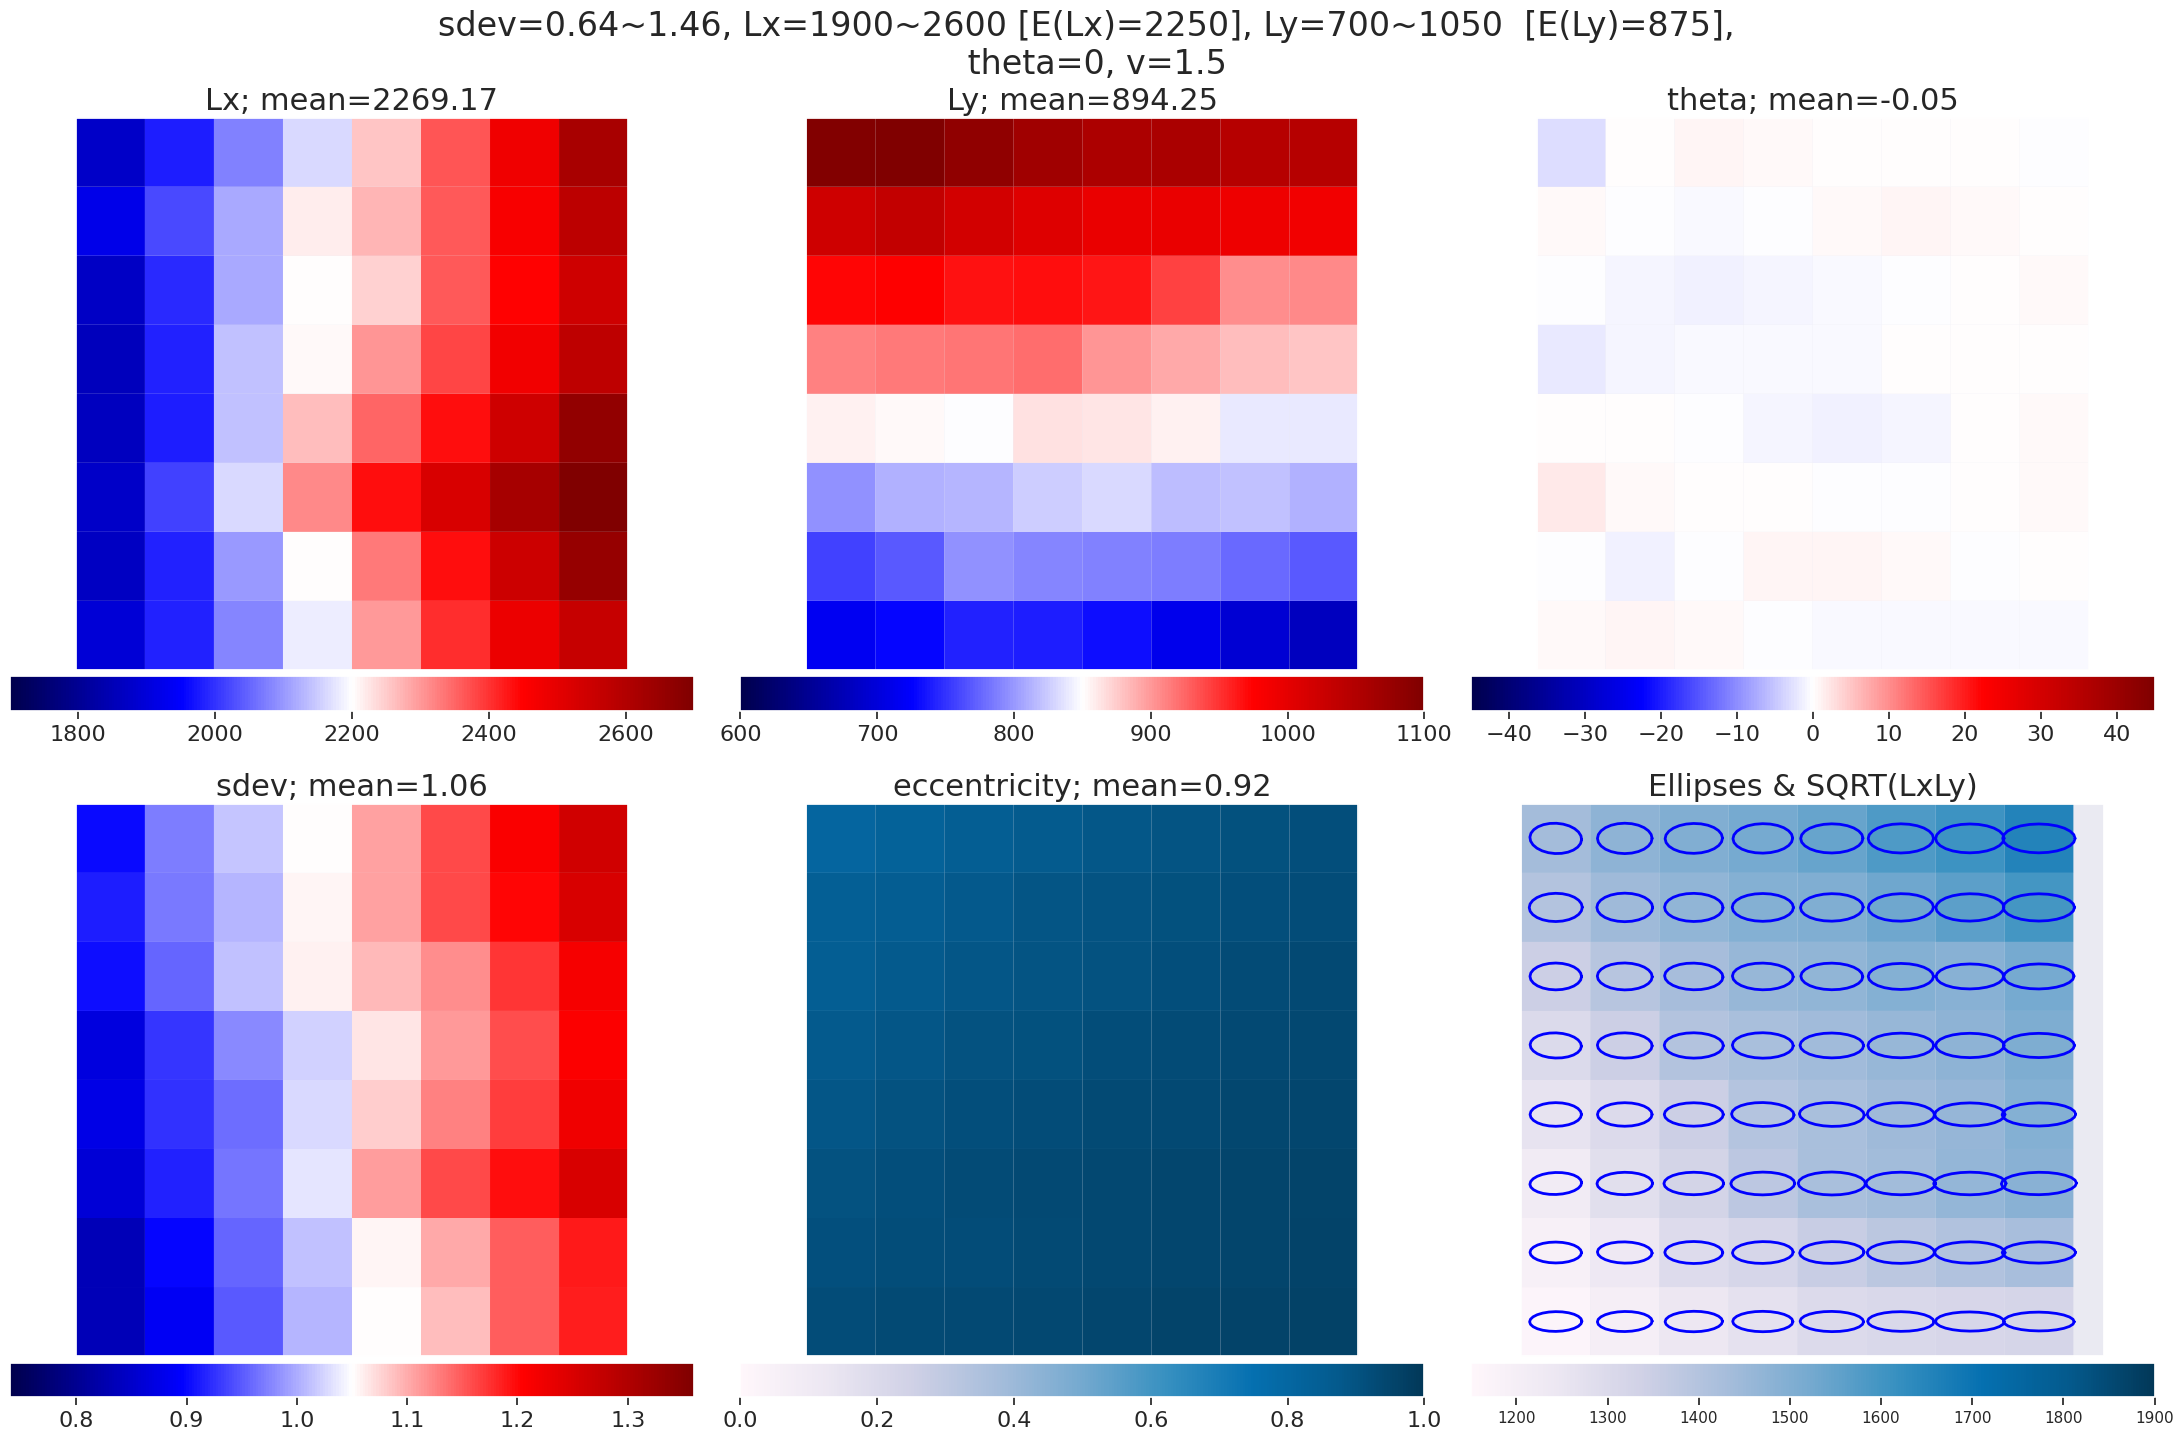

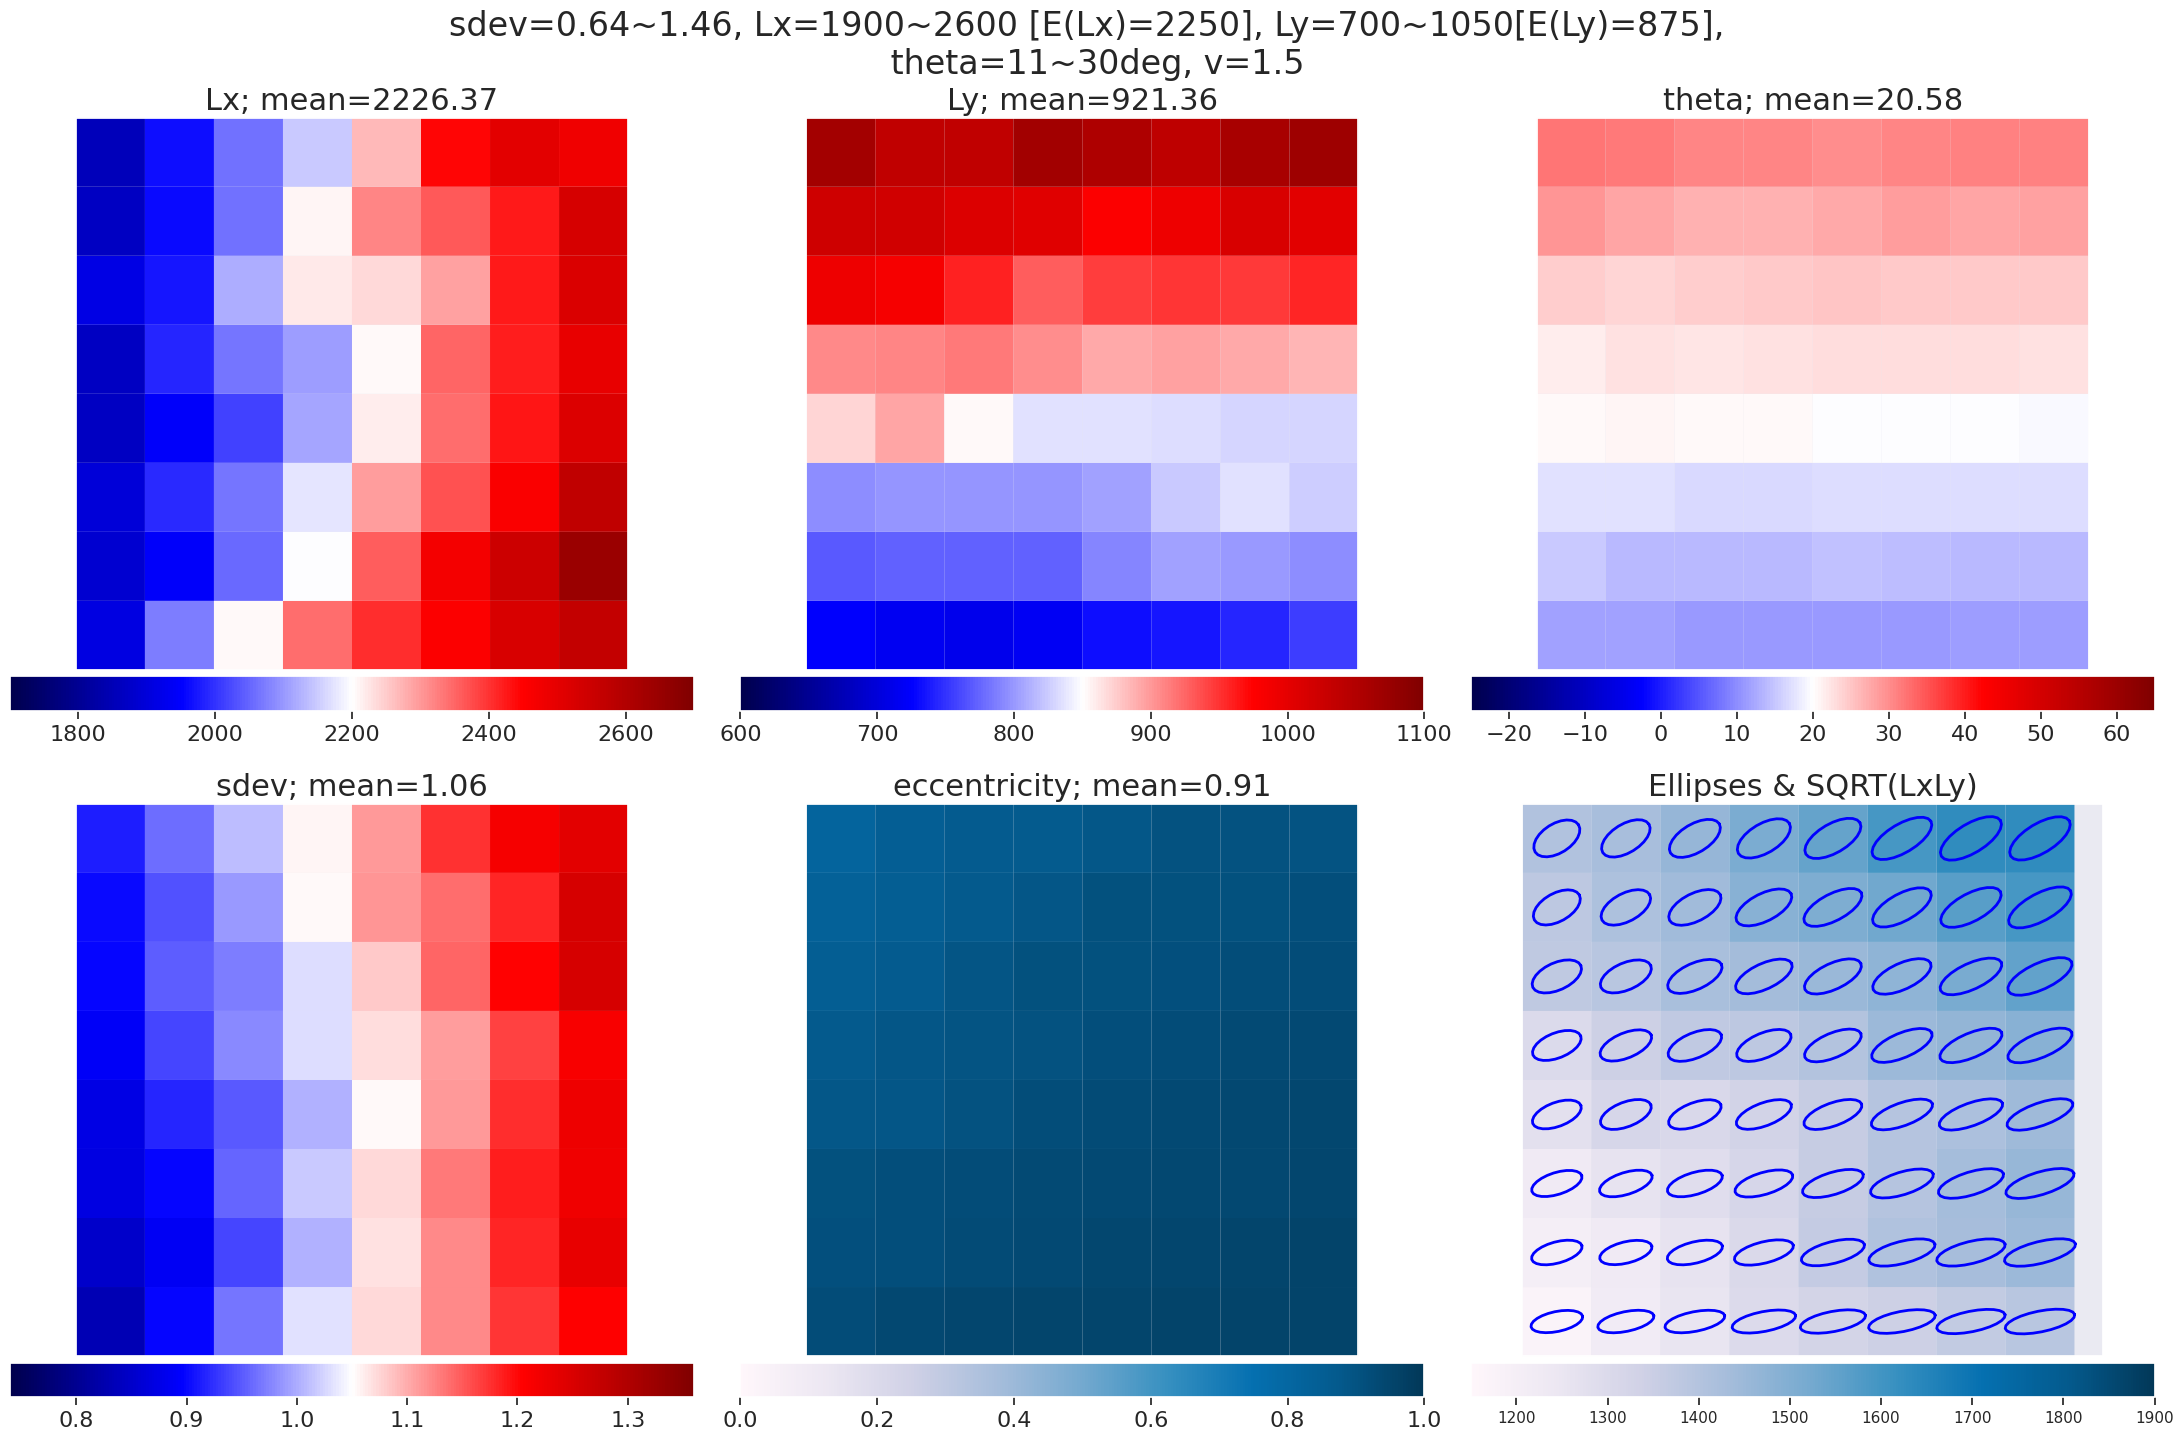

In [29]:
zipper = zip(
    simulated_ellipse_ncfiles,
    simulated_ellipse_verbals,
    simulated_ellipse_figfiles,
    vminss,
    vmaxss,
    check_flips,
)
for (
    simulated_ellipse_ncfile,
    simulated_ellipse_verbal,
    simulated_ellipse_figfile,
    vmins,
    vmaxs,
    check_flip,
) in zipper:
    parm_cubes = iris.load(simulated_ellipse_ncfile)
    plot_parms(parm_cubes, simulated_ellipse_verbal, vmins, vmaxs, check_flip)
    plt.savefig(simulated_ellipse_figfile, dpi=300)

In [30]:
def plot_parms_diff(parm_cubes, expected_parm_cubes, verbal_description):
    # plt.subplots(nrows, ncols, figsize=(width, height))
    fig, axs = plt.subplots(
        2, 2, figsize=(15, 15), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    Lx, correct_Lx = (
        parm_cubes.extract("Lx")[0],
        expected_parm_cubes.extract("Lx")[0],
    )
    Ly, correct_Ly = (
        parm_cubes.extract("Ly")[0],
        expected_parm_cubes.extract("Ly")[0],
    )
    theta, correct_theta = (
        parm_cubes.extract("theta")[0],
        expected_parm_cubes.extract("theta")[0],
    )
    Lx2, Ly2, theta2 = swap_Lx_Ly_if_Lx_lt_Ly(Lx, Ly, theta)
    theta_x, correct_theta_x = theta2.copy(), correct_theta.copy()
    theta_x.convert_units("degrees")
    correct_theta_x.convert_units("degrees")
    sdev, correct_sdev = (
        parm_cubes.extract("standard_deviation")[0],
        expected_parm_cubes.extract("standard_deviation")[0],
    )
    #
    Lx_bias = correct_Lx - Lx2
    Ly_bias = correct_Ly - Ly2
    theta_bias = correct_theta_x - theta_x
    sdev_bias = correct_sdev - sdev
    #
    Lx_bias_rmse = np.sqrt(np.mean(np.square(Lx_bias.data)))
    Ly_bias_rmse = np.sqrt(np.mean(np.square(Ly_bias.data)))
    theta_bias_rmse = np.sqrt(np.mean(np.square(theta_bias.data)))
    sdev_bias_rmse = np.sqrt(np.mean(np.square(sdev_bias.data)))
    #
    zipper = zip(
        axs.flatten(),
        [Lx_bias, Ly_bias, theta_bias, sdev_bias],
        ["Lx_bias", "Ly_bias", "theta_bias", "sdev_bias"],
        [
            (-50, 50),
            (-50, 50),
            (-10, 10),
            (-0.05, 0.05),
        ],
        [Lx_cmap, Ly_cmap, theta_cmap, sdev_cmap],
        [Lx_bias_rmse, Ly_bias_rmse, theta_bias_rmse, sdev_bias_rmse],
    )
    for ax, cube, cube_name, vmin_vmax, cmap, parm_mean in zipper:
        pcolor_parm(
            ax,
            cube,
            cube_name,
            vmin_vmax,
            cmap,
            parm_mean=parm_mean,
            parm_mean_name="rmse",
        )
    fig.suptitle(verbal_description, size=24)
    plt.tight_layout()

In [31]:
def correct_parms_stationary(parm_cubes, correct_parms_tuple):
    """
    (Lx, Ly, theta, sdev)
    """

    def fill_parms(cube_template, val):
        ans = cube_template.copy()
        ans.data[:] = val
        return ans

    ans_cubelist = iris.cube.CubeList()
    ans_cubelist.append(
        fill_parms(parm_cubes.extract("Lx")[0], correct_parms_tuple[0])
    )
    ans_cubelist.append(
        fill_parms(parm_cubes.extract("Ly")[0], correct_parms_tuple[1])
    )
    ans_cubelist.append(
        fill_parms(parm_cubes.extract("theta")[0], correct_parms_tuple[2])
    )
    ans_cubelist.append(
        fill_parms(
            parm_cubes.extract("standard_deviation")[0], correct_parms_tuple[3]
        )
    )
    return ans_cubelist

<iris 'Cube' of unknown / (km) (latitude: 8; longitude: 8)>
Lx_bias
-28.122314 48.417236
<iris 'Cube' of unknown / (km) (latitude: 8; longitude: 8)>
Ly_bias
-40.308594 41.64917
<iris 'Cube' of unknown / (degrees) (latitude: 8; longitude: 8)>
theta_bias
-9.091462 11.861103
<iris 'Cube' of unknown / (K) (latitude: 8; longitude: 8)>
sdev_bias
-0.023773432 0.020307004
<iris 'Cube' of unknown / (km) (latitude: 8; longitude: 8)>
Lx_bias
-42.054077 88.7771
<iris 'Cube' of unknown / (km) (latitude: 8; longitude: 8)>
Ly_bias
-111.17847 40.56311
<iris 'Cube' of unknown / (degrees) (latitude: 8; longitude: 8)>
theta_bias
-9.006653 45.13802
<iris 'Cube' of unknown / (K) (latitude: 8; longitude: 8)>
sdev_bias
-0.01866144 0.017307758
<iris 'Cube' of unknown / (km) (latitude: 8; longitude: 8)>
Lx_bias
-80.43579 60.683594
<iris 'Cube' of unknown / (km) (latitude: 8; longitude: 8)>
Ly_bias
-40.887817 32.89673
<iris 'Cube' of unknown / (degrees) (latitude: 8; longitude: 8)>
theta_bias
-3.2539473 5.90225

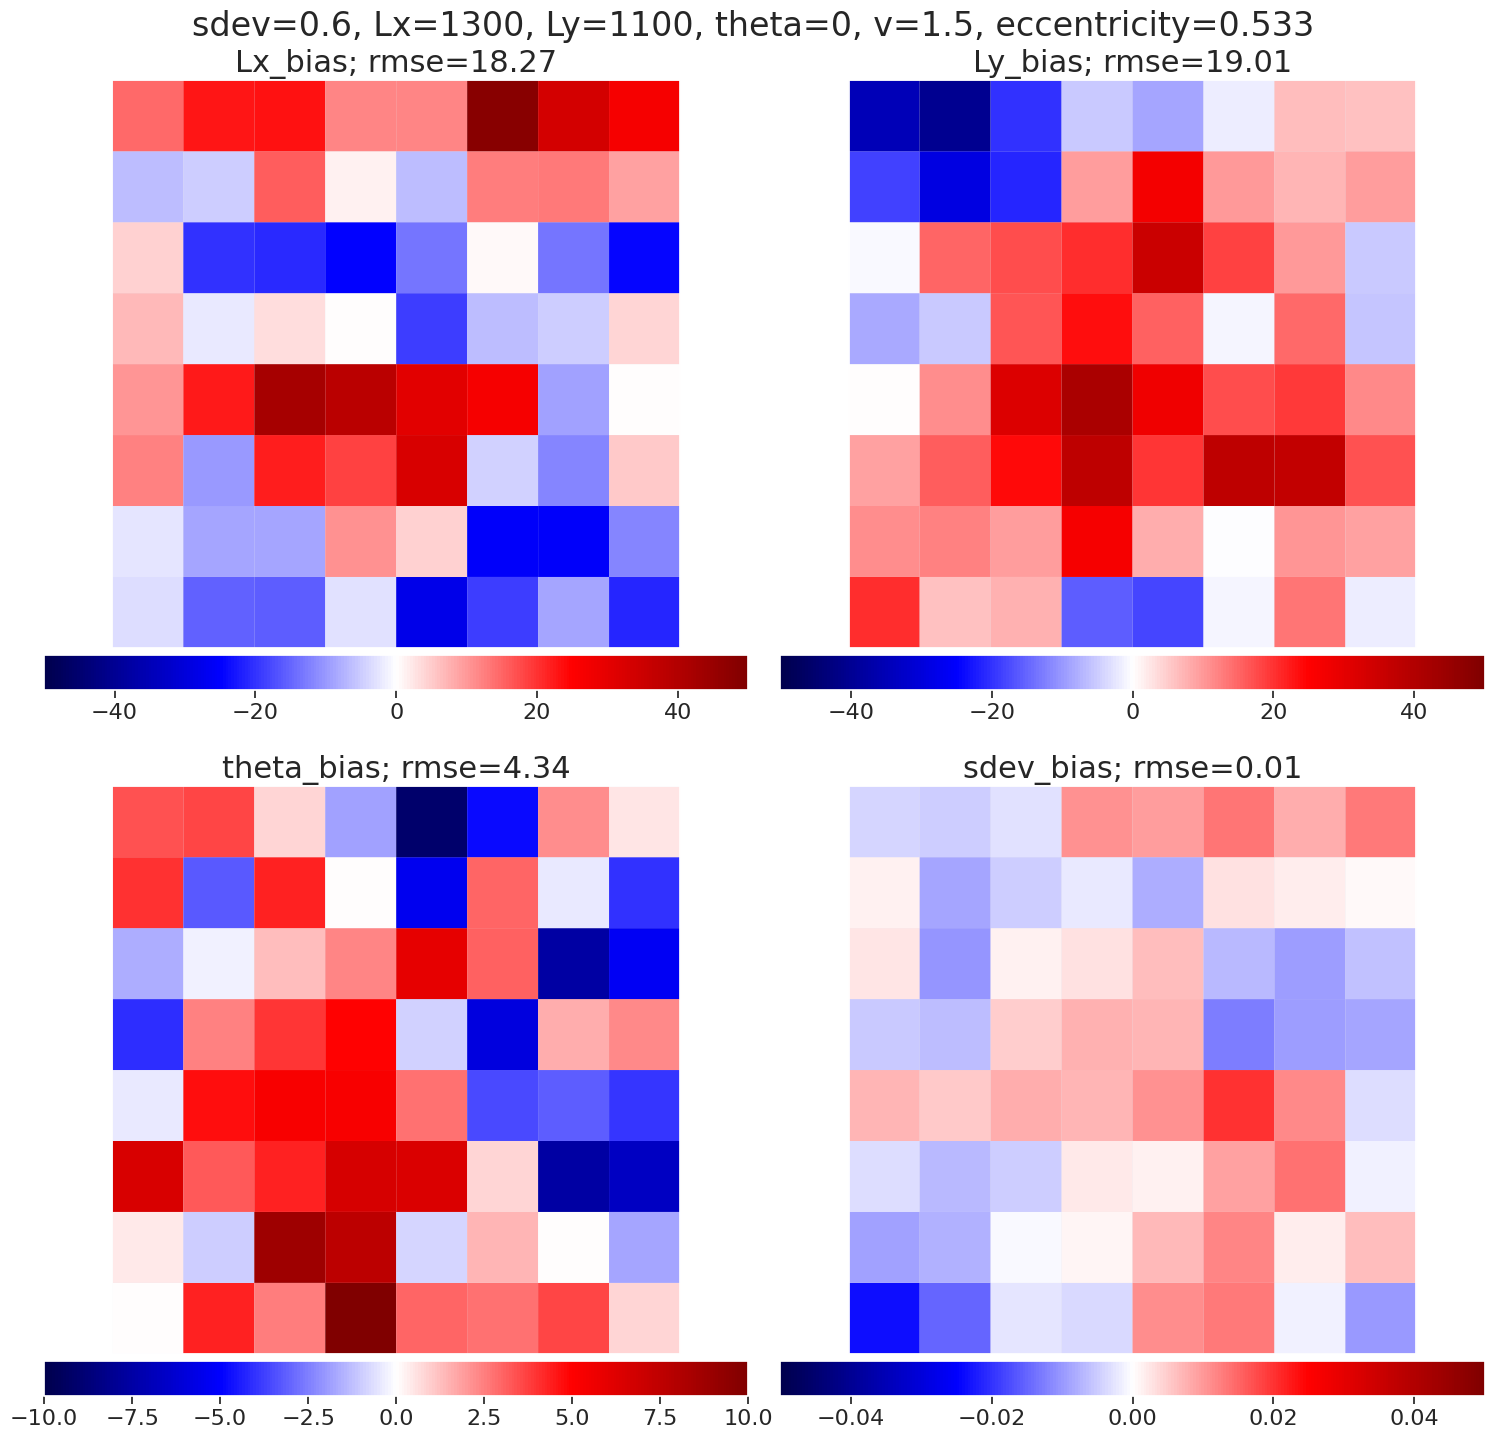

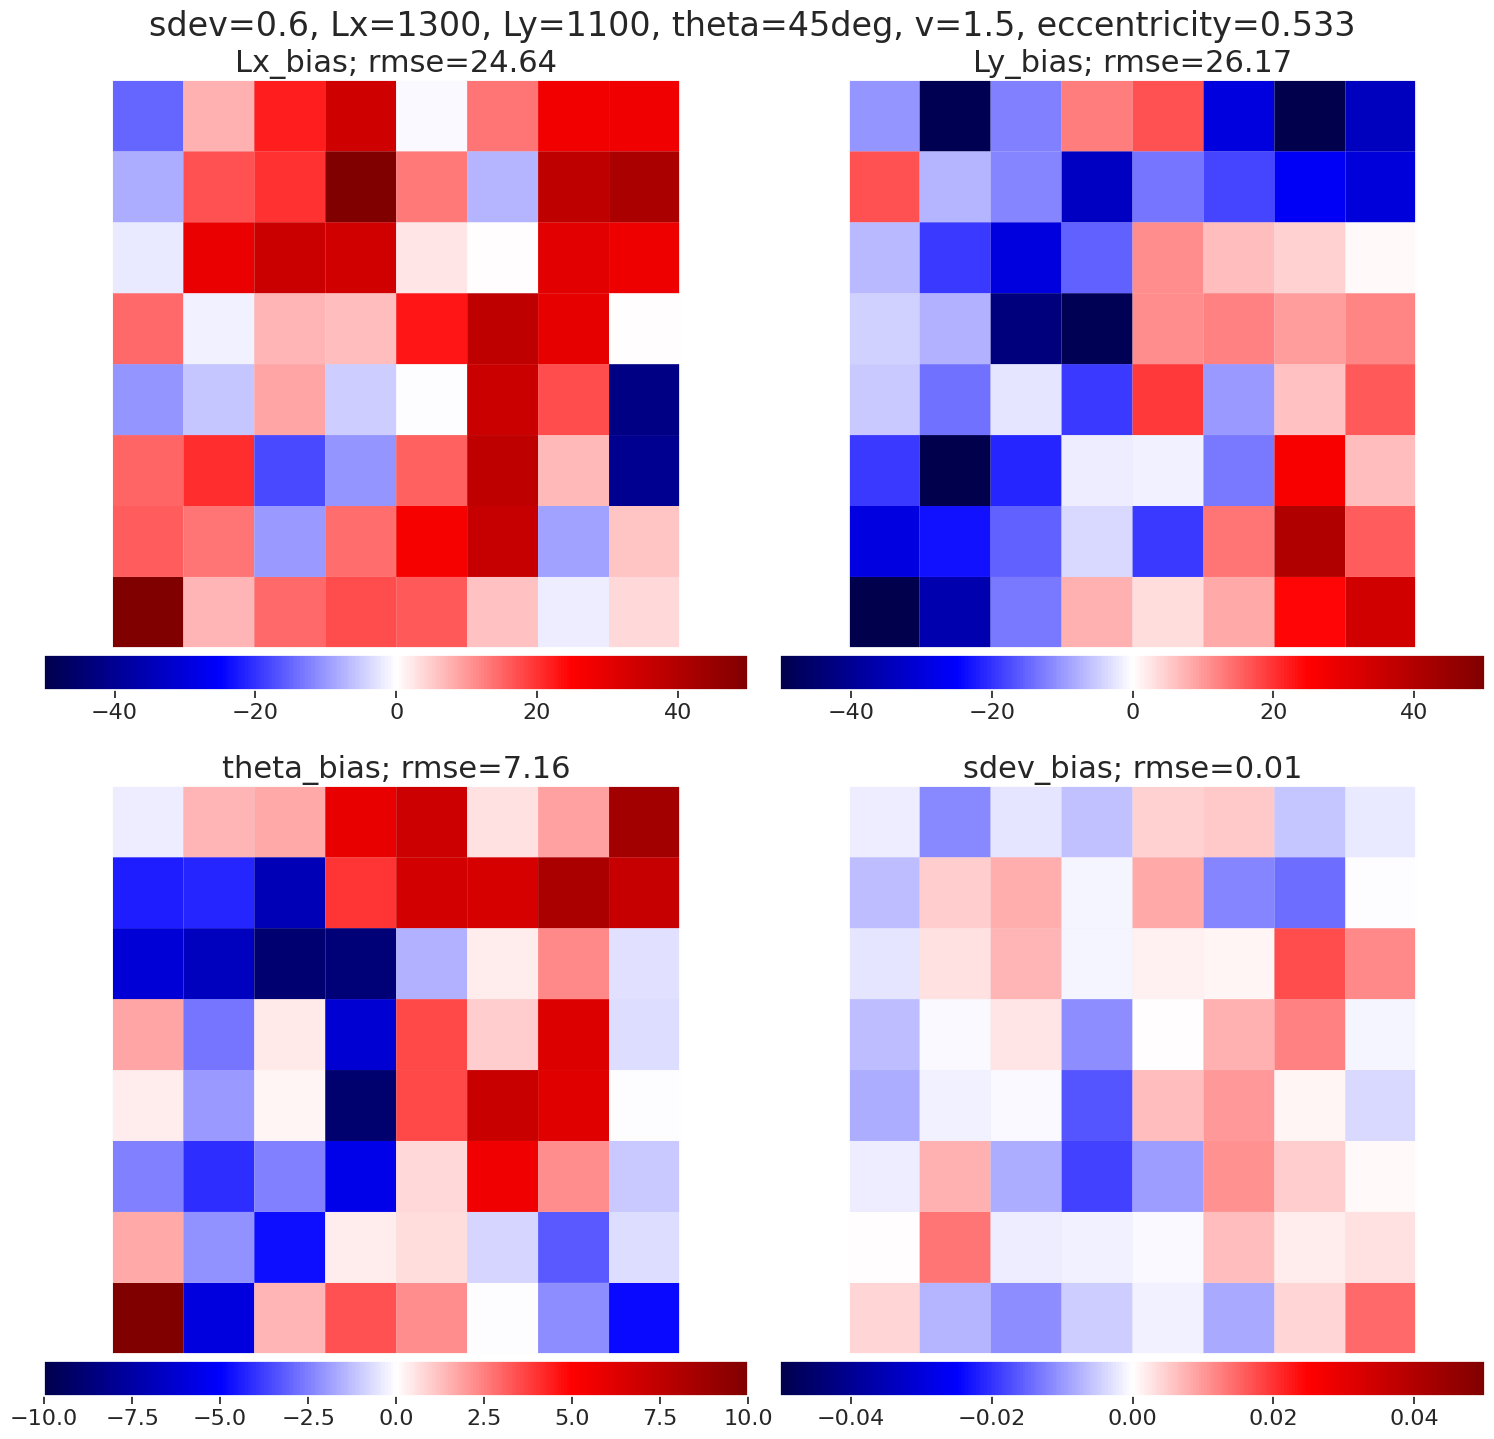

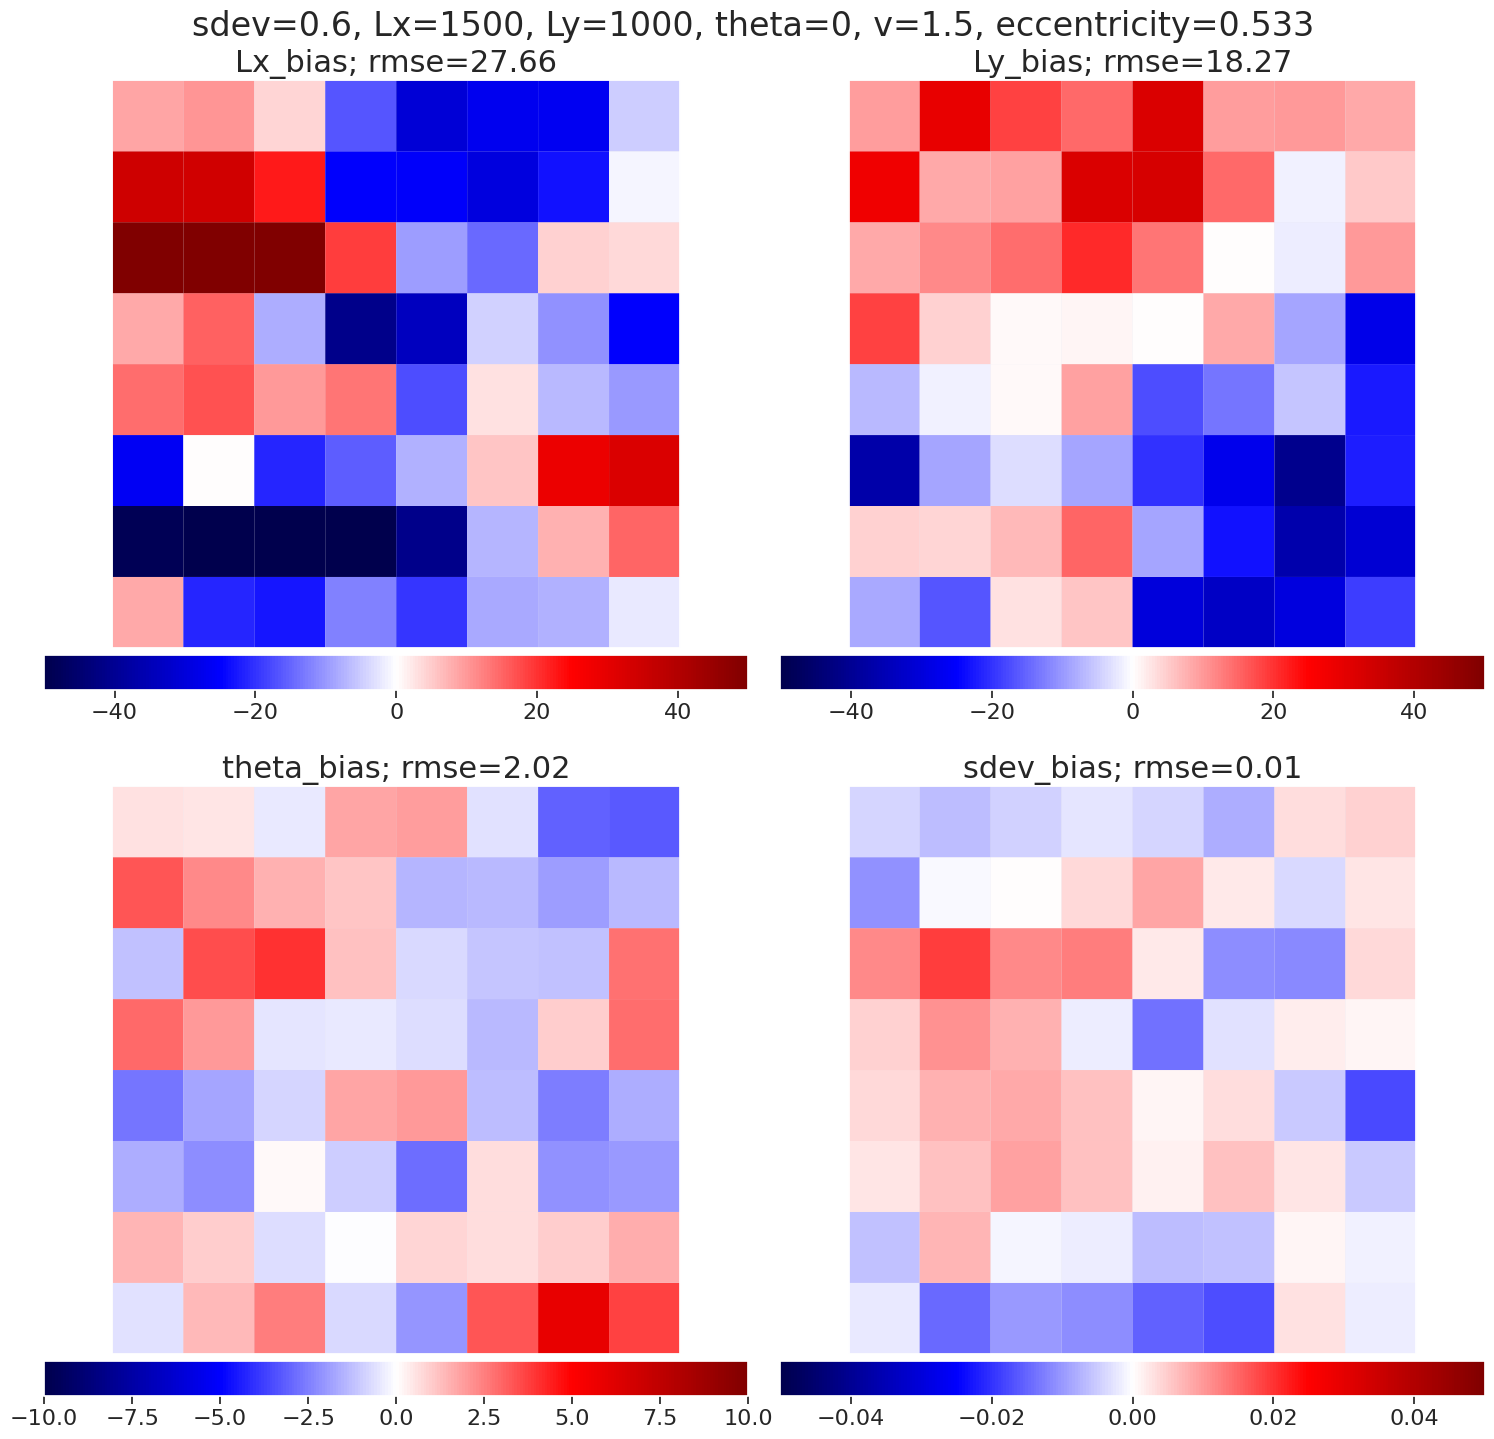

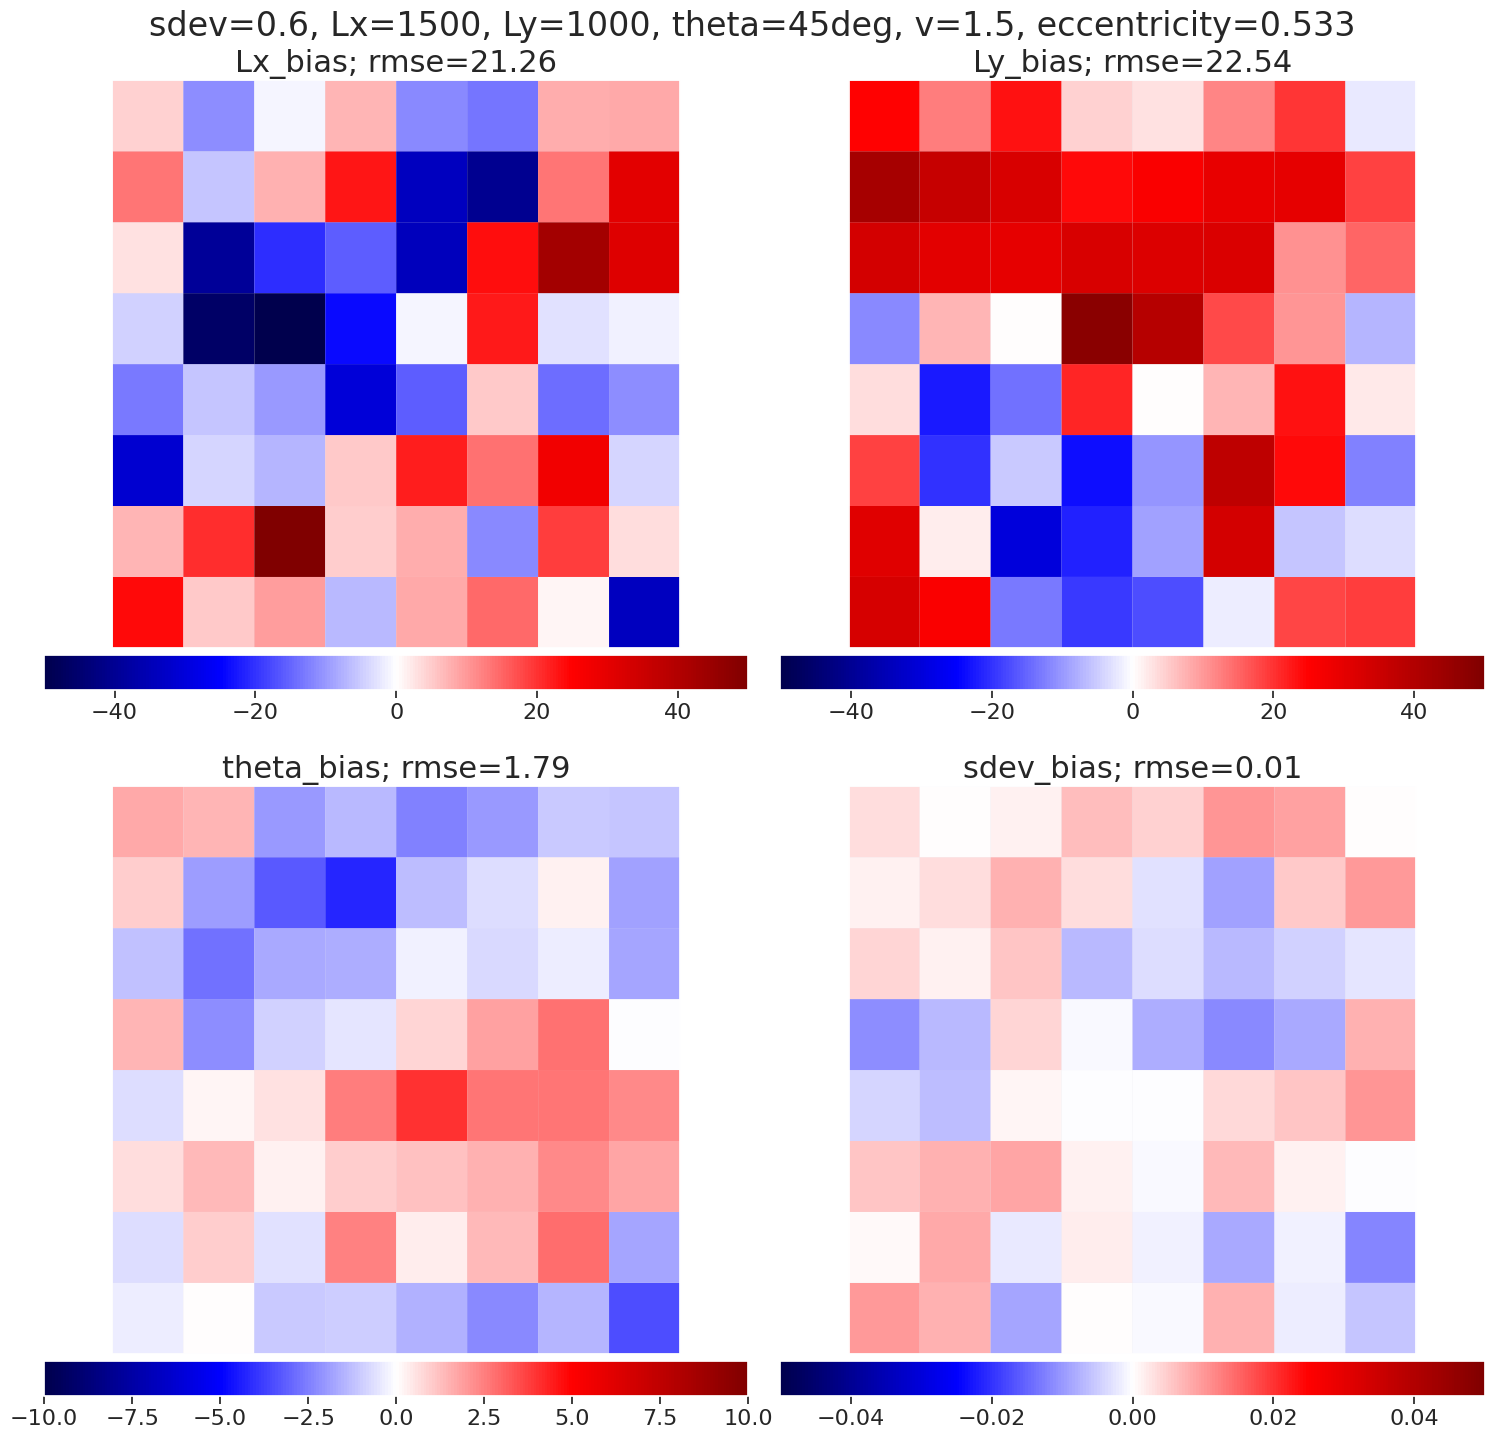

In [32]:
zipper = zip(
    simulated_ellipse_ncfiles[1:5],
    simulated_ellipse_verbals[1:5],
    correct_parms[1:5],
)
for simulated_ellipse_ncfile, simulated_ellipse_verbal, correct_parm in zipper:
    parm_cubes = iris.load(simulated_ellipse_ncfile)
    correct_parm_cubes = correct_parms_stationary(parm_cubes, correct_parm)
    plot_parms_diff(parm_cubes, correct_parm_cubes, simulated_ellipse_verbal)